# Credit card customer segmentation

I followed the notebook for kmean and kprototype for clustering, and use shap to explain the difference among the clusters

notebooks reference:

1. https://github.com/AntonsRuberts/datascience_marketing/blob/master/KMeans_vs_KPrototypes.ipynb

2. https://github.com/AntonsRuberts/datascience_marketing/blob/master/segment_profiling.ipynb

3. https://github.com/zachzazueta/telecom_churn_project/blob/master/Notebook%202%20-%20Cleaning%20and%20KPrototypes2.ipynb

4. https://github.com/zachzazueta/telecom_churn_project/blob/master/Notebook%201%20-%20Cleaning%20and%20EDA.ipynb

## Define the problom

## Solution

## loading data and libraries

In [1]:
import pandas as pd
import numpy as np

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go

# for data preprocessing
from sklearn.preprocessing import PowerTransformer, StandardScaler

# for dimention reduction and visualization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# for correlation analysis
from scipy import stats
import phik
from phik import resources, report

# models
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from lightgbm import LGBMClassifier

# metrics
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import shap
from sklearn.model_selection import cross_val_score

In [59]:
# import data
df = pd.read_csv('./BankChurners.csv')

In [60]:
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1              44  ...        8256.0                  864           7392.0   
2              36  ...        3418.0                    0           3418.0   
3              34  ...        3313.0                 2517            796.0   
4              21  ...        4716.0                    0           4716.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   Avg_Utilization_Ratio  \
0                  0.061   
1                  0.105   
2                  0.000   
3                  0.760   
4                  0.000   

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
0                                           0.000093                                                                                    
1                                           0.000057                                                                                    
2                                           0.000021                                                                                    
3                                           0.000134                                                                                    
4                                           0.000022                                                                                    

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
0                                            0.99991                                                                                   
1                                            0.99994                                                                                   
2                                            0.99998                                                                                   
3                                            0.99987                                                                                   
4                                            0.99998                                                                                   

[5 rows x 23 columns]

In [5]:
df.shape

(10127, 23)

In [6]:
# drop 3 columns 'CLIENTNUM', 
# and 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'
# and 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
# because those columns are not related to the analysis
df = df.drop(df.columns[[0,-2,-1]], axis=1)
df.head()

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      M                3     High School   
1  Existing Customer            49      F                5        Graduate   
2  Existing Customer            51      M                3        Graduate   
3  Existing Customer            40      F                4     High School   
4  Existing Customer            40      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue              39   
1         Single  Less than $40K          Blue              44   
2        Married    $80K - $120K          Blue              36   
3        Unknown  Less than $40K          Blue              34   
4        Married     $60K - $80K          Blue              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [8]:
# categorical features, remove 'Attrition_Flag'
cat_cols = df.drop(columns='Attrition_Flag').select_dtypes(include="O").columns
cat_cols

Index(['Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category'],
      dtype='object')

In [9]:
# check the categories in each categorical features
for col in cat_cols:
    print(f'Unique valus and their counts in feature {col}')
    print(df[col].value_counts())
    print()

Unique valus and their counts in feature Gender
F    5358
M    4769
Name: Gender, dtype: int64

Unique valus and their counts in feature Education_Level
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

Unique valus and their counts in feature Marital_Status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64

Unique valus and their counts in feature Income_Category
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64

Unique valus and their counts in feature Card_Category
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64



**Unknown values in 3 categorical features**. I will use oneHot encoding to all categorical features

In [10]:
# for numerical features
df.describe().T

count         mean          std     min       25%  \
Customer_Age              10127.0    46.325960     8.016814    26.0    41.000   
Dependent_count           10127.0     2.346203     1.298908     0.0     1.000   
Months_on_book            10127.0    35.928409     7.986416    13.0    31.000   
Total_Relationship_Count  10127.0     3.812580     1.554408     1.0     3.000   
Months_Inactive_12_mon    10127.0     2.341167     1.010622     0.0     2.000   
Contacts_Count_12_mon     10127.0     2.455317     1.106225     0.0     2.000   
Credit_Limit              10127.0  8631.953698  9088.776650  1438.3  2555.000   
Total_Revolving_Bal       10127.0  1162.814061   814.987335     0.0   359.000   
Avg_Open_To_Buy           10127.0  7469.139637  9090.685324     3.0  1324.500   
Total_Amt_Chng_Q4_Q1      10127.0     0.759941     0.219207     0.0     0.631   
Total_Trans_Amt           10127.0  4404.086304  3397.129254   510.0  2155.500   
Total_Trans_Ct            10127.0    64.858695    23.472570    10.0    45.000   
Total_Ct_Chng_Q4_Q1       10127.0     0.712222     0.238086     0.0     0.582   
Avg_Utilization_Ratio     10127.0     0.274894     0.275691     0.0     0.023   

                               50%        75%        max  
Customer_Age                46.000     52.000     73.000  
Dependent_count              2.000      3.000      5.000  
Months_on_book              36.000     40.000     56.000  
Total_Relationship_Count     4.000      5.000      6.000  
Months_Inactive_12_mon       2.000      3.000      6.000  
Contacts_Count_12_mon        2.000      3.000      6.000  
Credit_Limit              4549.000  11067.500  34516.000  
Total_Revolving_Bal       1276.000   1784.000   2517.000  
Avg_Open_To_Buy           3474.000   9859.000  34516.000  
Total_Amt_Chng_Q4_Q1         0.736      0.859      3.397  
Total_Trans_Amt           3899.000   4741.000  18484.000  
Total_Trans_Ct              67.000     81.000    139.000  
Total_Ct_Chng_Q4_Q1          0.702      0.818      3.714  
Avg_Utilization_Ratio        0.176      0.503      0.999

In [12]:
# lists of numerical features

num_cols = df.select_dtypes(exclude='O').columns
num_cols

Index(['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'],
      dtype='object')

**Besides the seperation of categorical and numerical features in data set. The data set contains demographic and behavioral (the use of credit card) information of customers**. Those information may help group people.

In [13]:
## demographic and behavirol features
demo_cols = list(cat_cols) + ['Customer_Age', 'Dependent_count']
demo_cols
behave_cols = [col for col in num_cols if col not in ['Customer_Age', 'Dependent_count']] 
print(f'{len(demo_cols)} demographic features: \n{demo_cols}')
print(f'\n{len(behave_cols)} behavioral features: \n{behave_cols}')

7 demographic features: 
['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Customer_Age', 'Dependent_count']

12 behavioral features: 
['Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


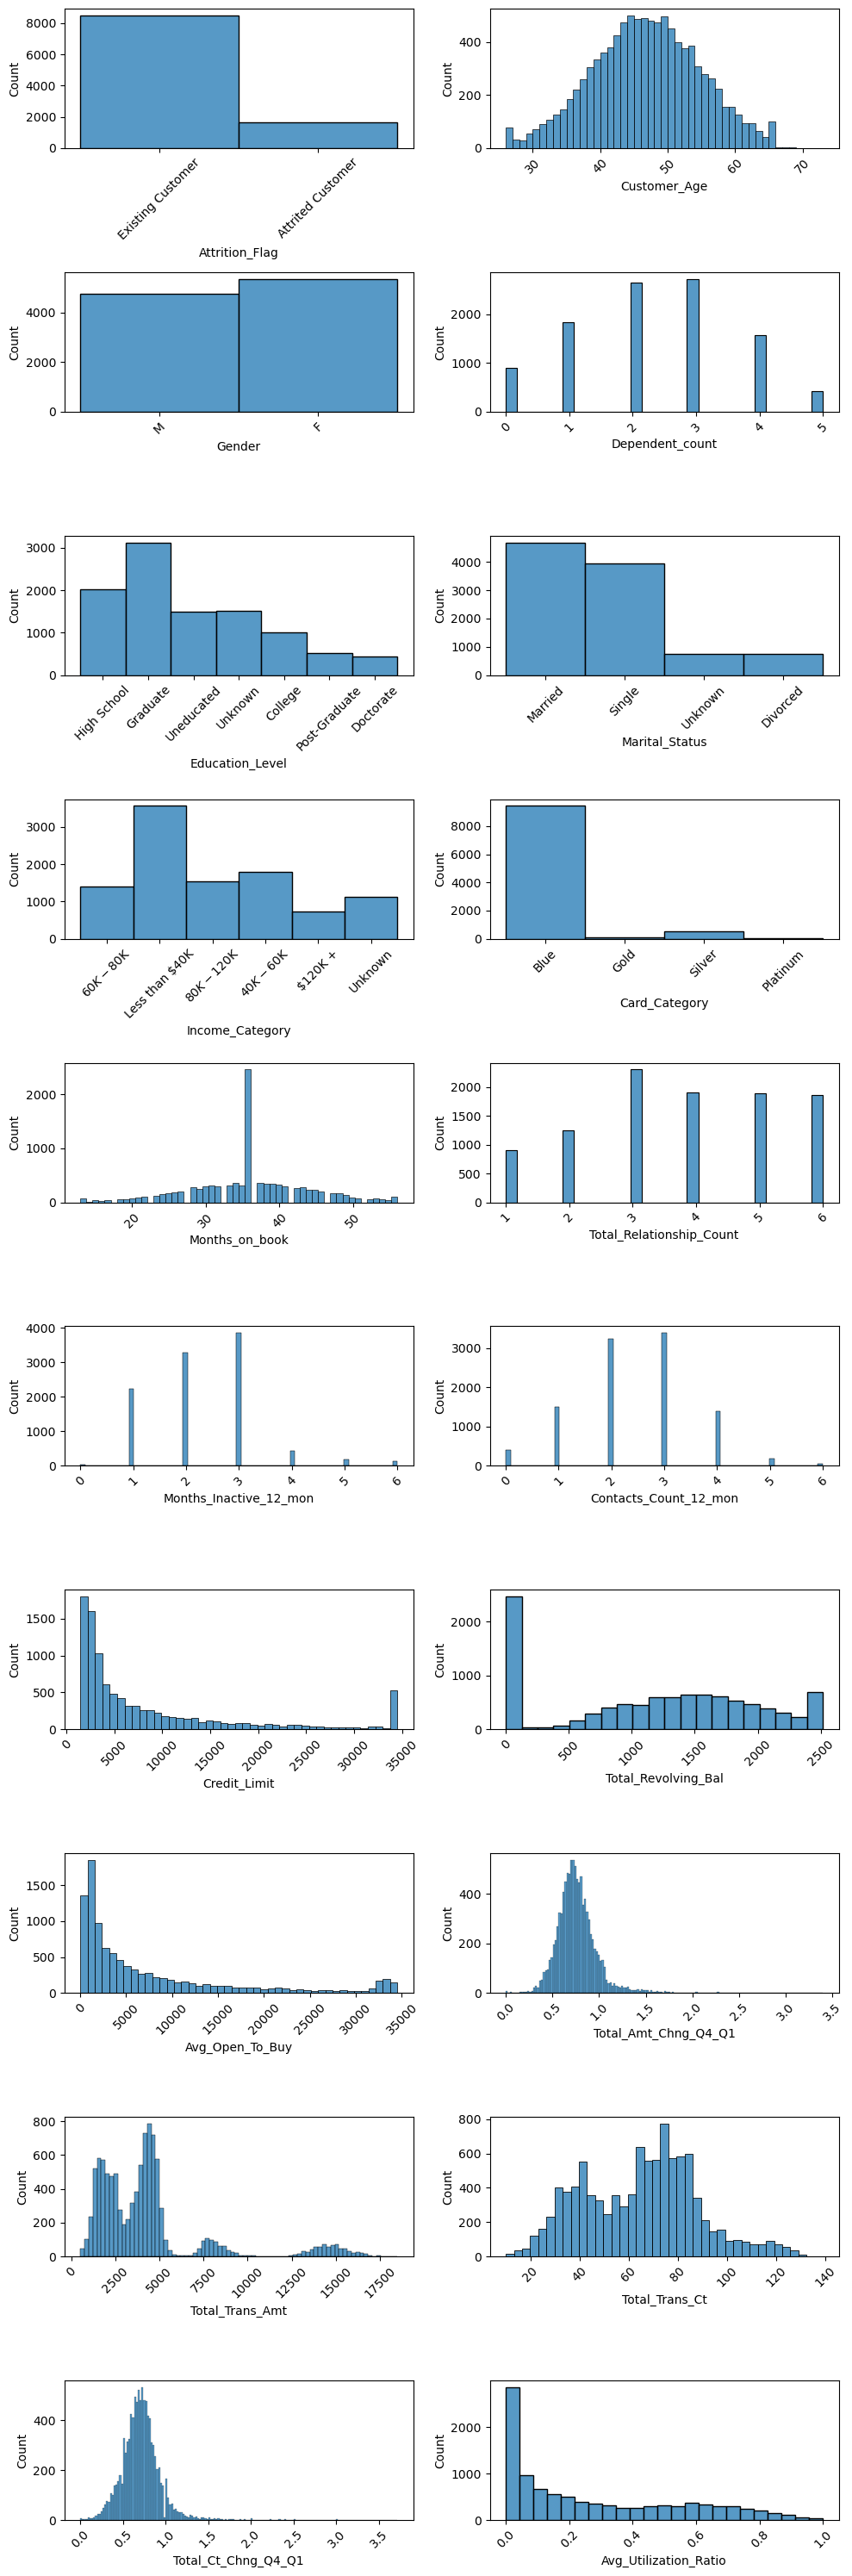

In [14]:
# check data distribution
fig = plt.figure(figsize=(10, 30))
# fig.subplots_adjust(hspace=0.8, wspace=0.8)
for i,var in enumerate(df.columns):
    ax = fig.add_subplot(10, 2, i+1)
    sns.histplot(df[var], ax=ax)
    ax.tick_params(axis='x', rotation=45)
#     ax.set_title(var)
plt.tight_layout()

In [15]:
# check the skewness of the numerical features. Can only work on numerical data
df[num_cols].skew()

Customer_Age               -0.033605
Dependent_count            -0.020826
Months_on_book             -0.106565
Total_Relationship_Count   -0.162452
Months_Inactive_12_mon      0.633061
Contacts_Count_12_mon       0.011006
Credit_Limit                1.666726
Total_Revolving_Bal        -0.148837
Avg_Open_To_Buy             1.661697
Total_Amt_Chng_Q4_Q1        1.732063
Total_Trans_Amt             2.041003
Total_Trans_Ct              0.153673
Total_Ct_Chng_Q4_Q1         2.064031
Avg_Utilization_Ratio       0.718008
dtype: float64

**Most numerical features have skewness, especially 'Months_Inactive_12_mon', 'Credit_Limit', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Ct_Chng_Q4_Q1' and 'Avg_Utilization_Ratio'**. PowerTransformer can be used to correct the skewness of the features before fitting into models

### Check the distribution of gender, education_level, matital_status in card categories

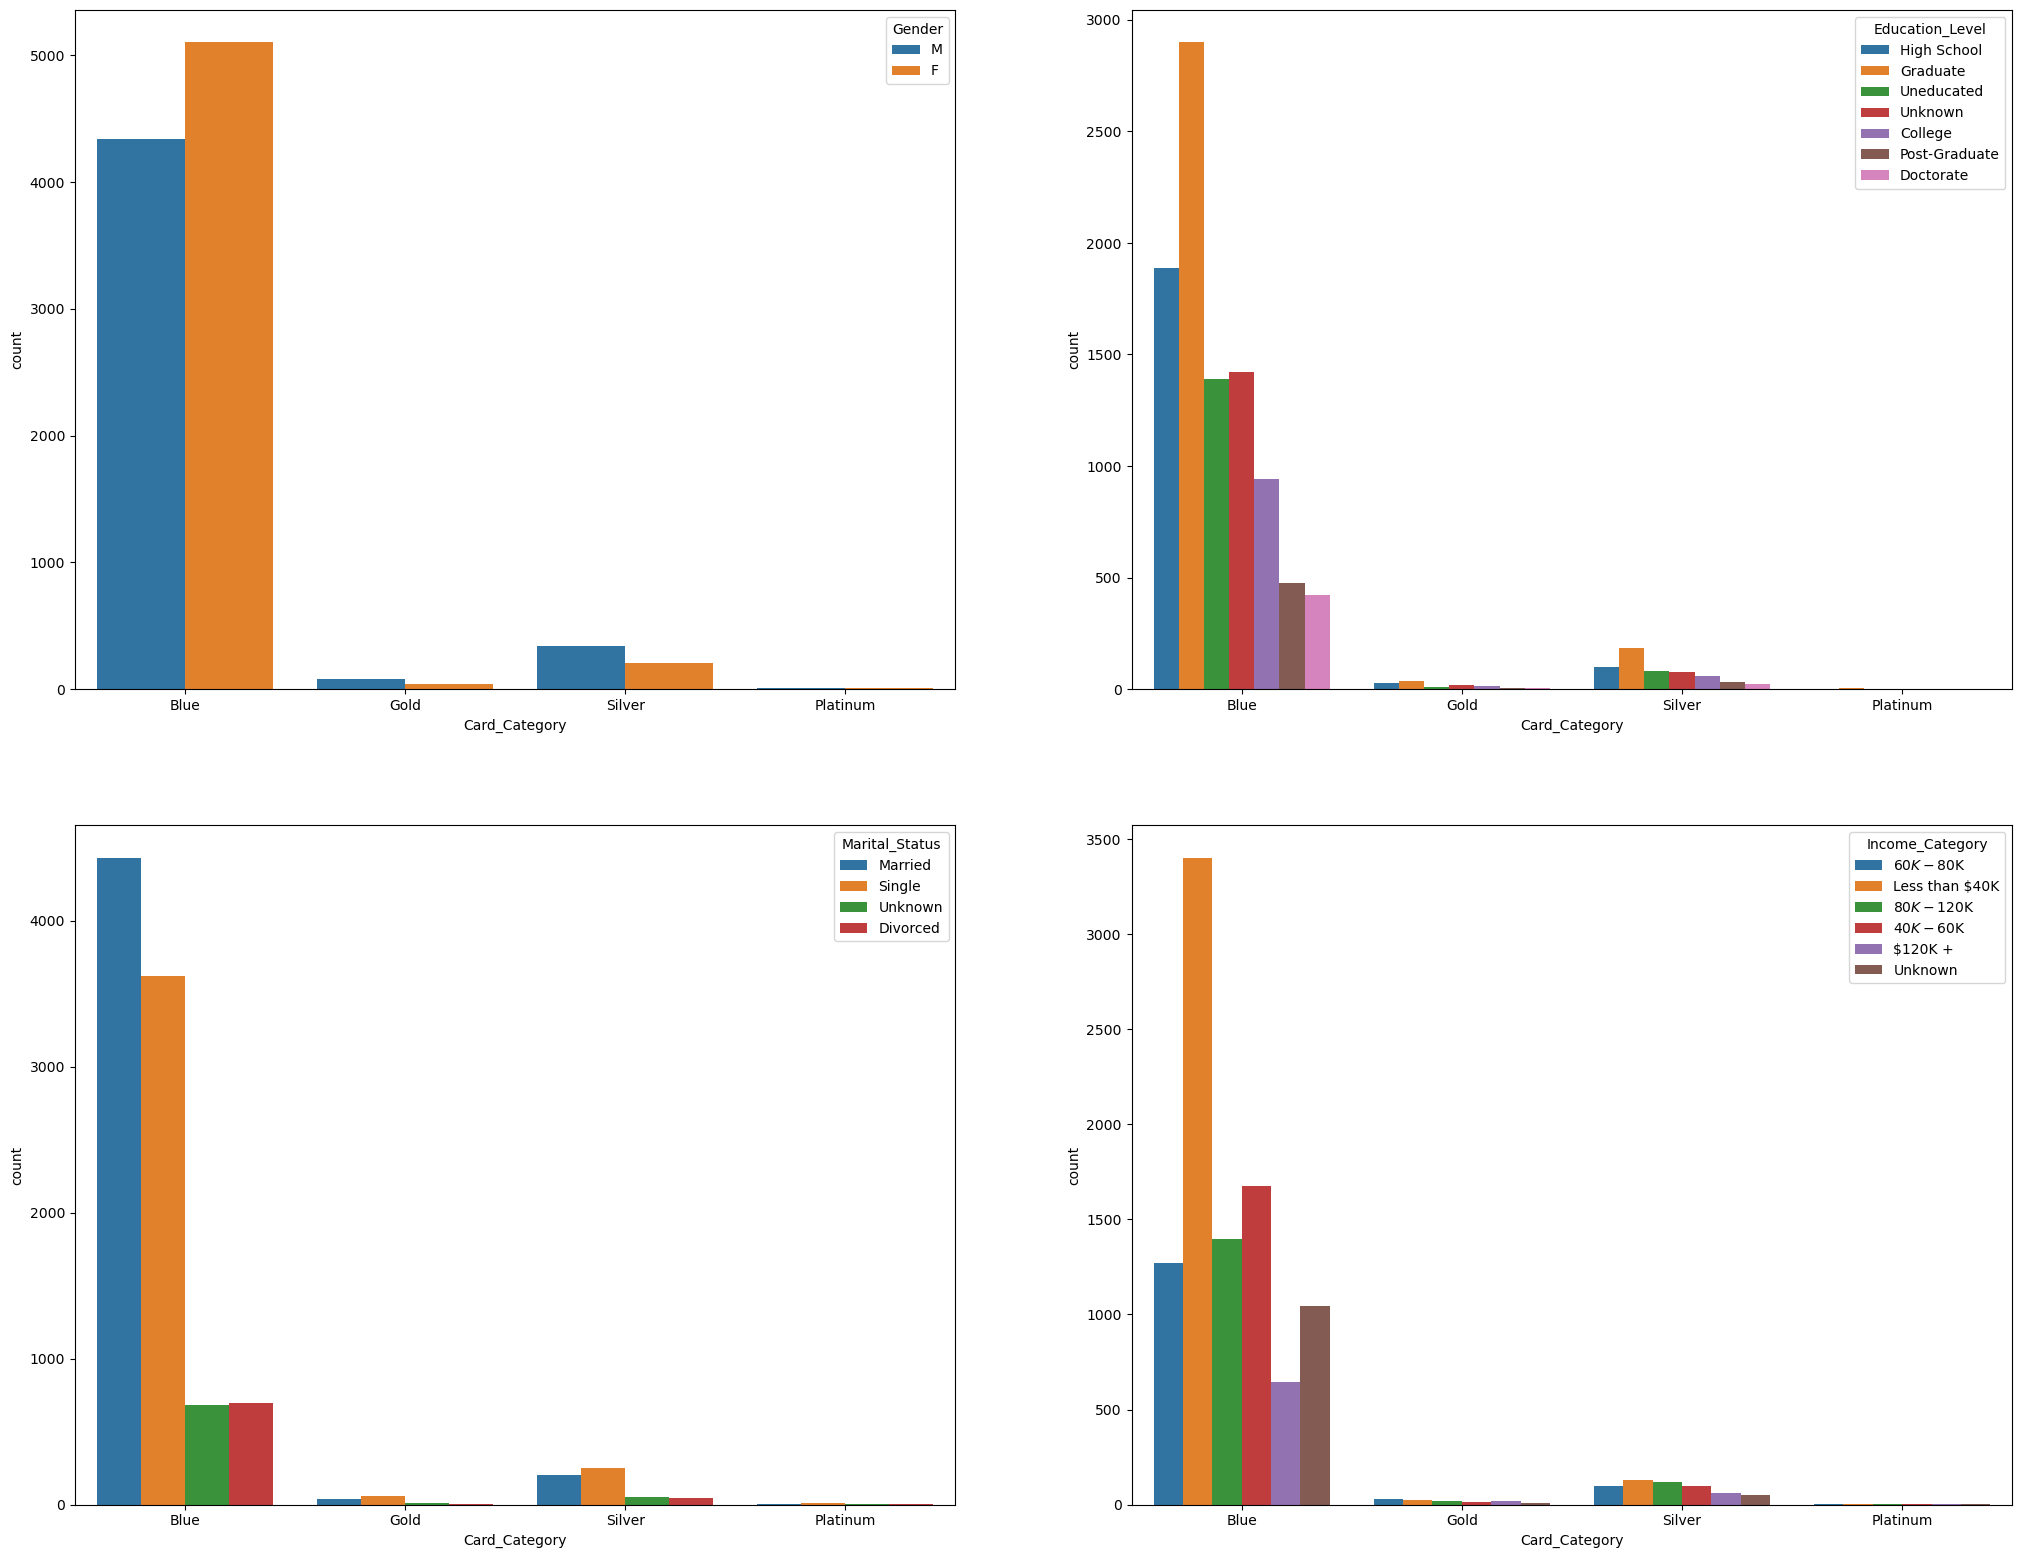

In [19]:
plt.figure(figsize=(25, 30))
for i in range(len(cat_cols)-1):
    plt.subplot(3, 2, i+1)
#     sns.boxplot(x=cat_cols[i], y="Card_Category", data=df, orient="h")
    sns.countplot(data=df, x='Card_Category', hue=cat_cols[i])

In [25]:
### missing values in numerical features
df[num_cols].isna().sum()

Customer_Age                0
Dependent_count             0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

### Check the correlation of features
I will use Pearson correlation and Spearman correlation for numerical features, phik for categorical and numberical

Text(0.5, 1.0, 'Pearson correlation Results')

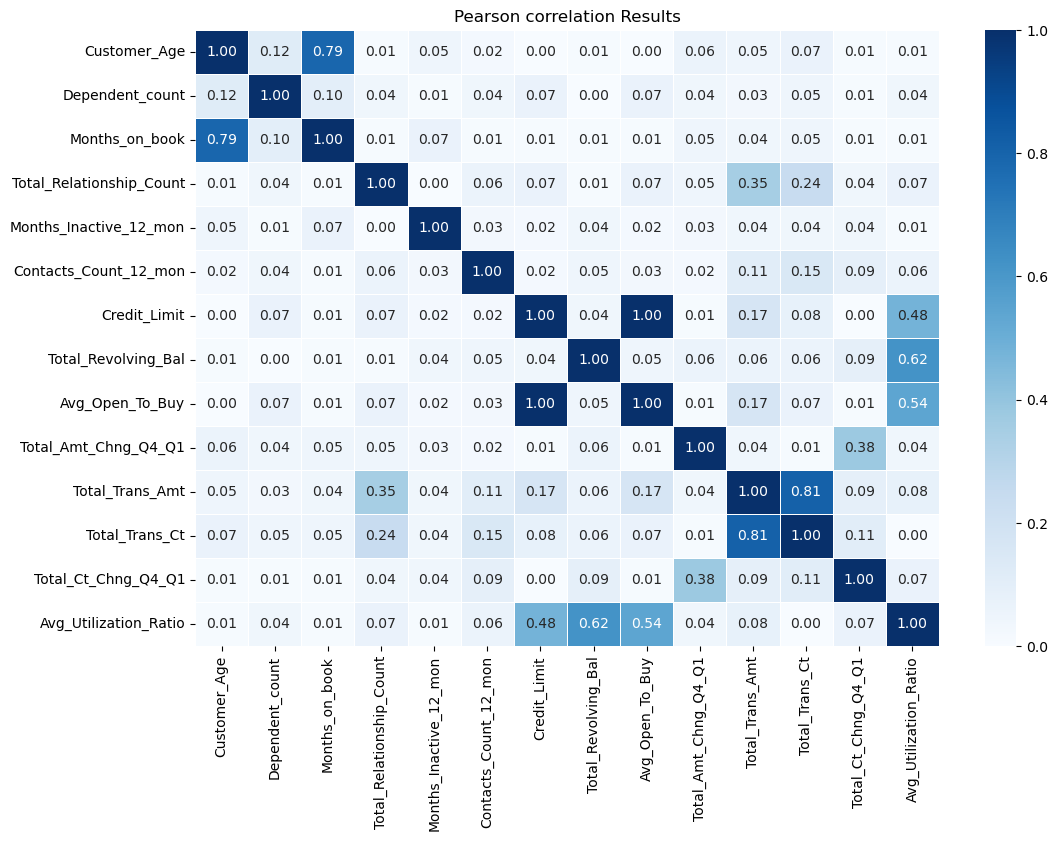

In [31]:
# Pearson correlation with absolute values
plt.figure(figsize=(12,8))
sns.heatmap(abs(round(df.corr(),2)), 
#             vmin=-1.0, 
#             vmax=1.0, 
            linewidths=0.5, 
            cmap='Blues', 
            annot=True, 
            fmt='.2f')
plt.title('Pearson correlation Results')

**Correlations between numerical features from Pearson r**
1. Credit_Limit and Avg_Open_To_Buy have correlation 1. I can choose one from them if they are useful for the model
1. Total_Trans_Ct and Total_Trans_Amt have correlation 0.81. I can choose one of them for model, or generate a new feature average_tran_amt (Total_Trans_Amt/Total_Trans_Ct). I will test the new feature in feature engineering part
2. Customer_Age and Months_on_Book have correlation 0.79. I can choose one from them if they are useful for the model

interval columns not set, guessing: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


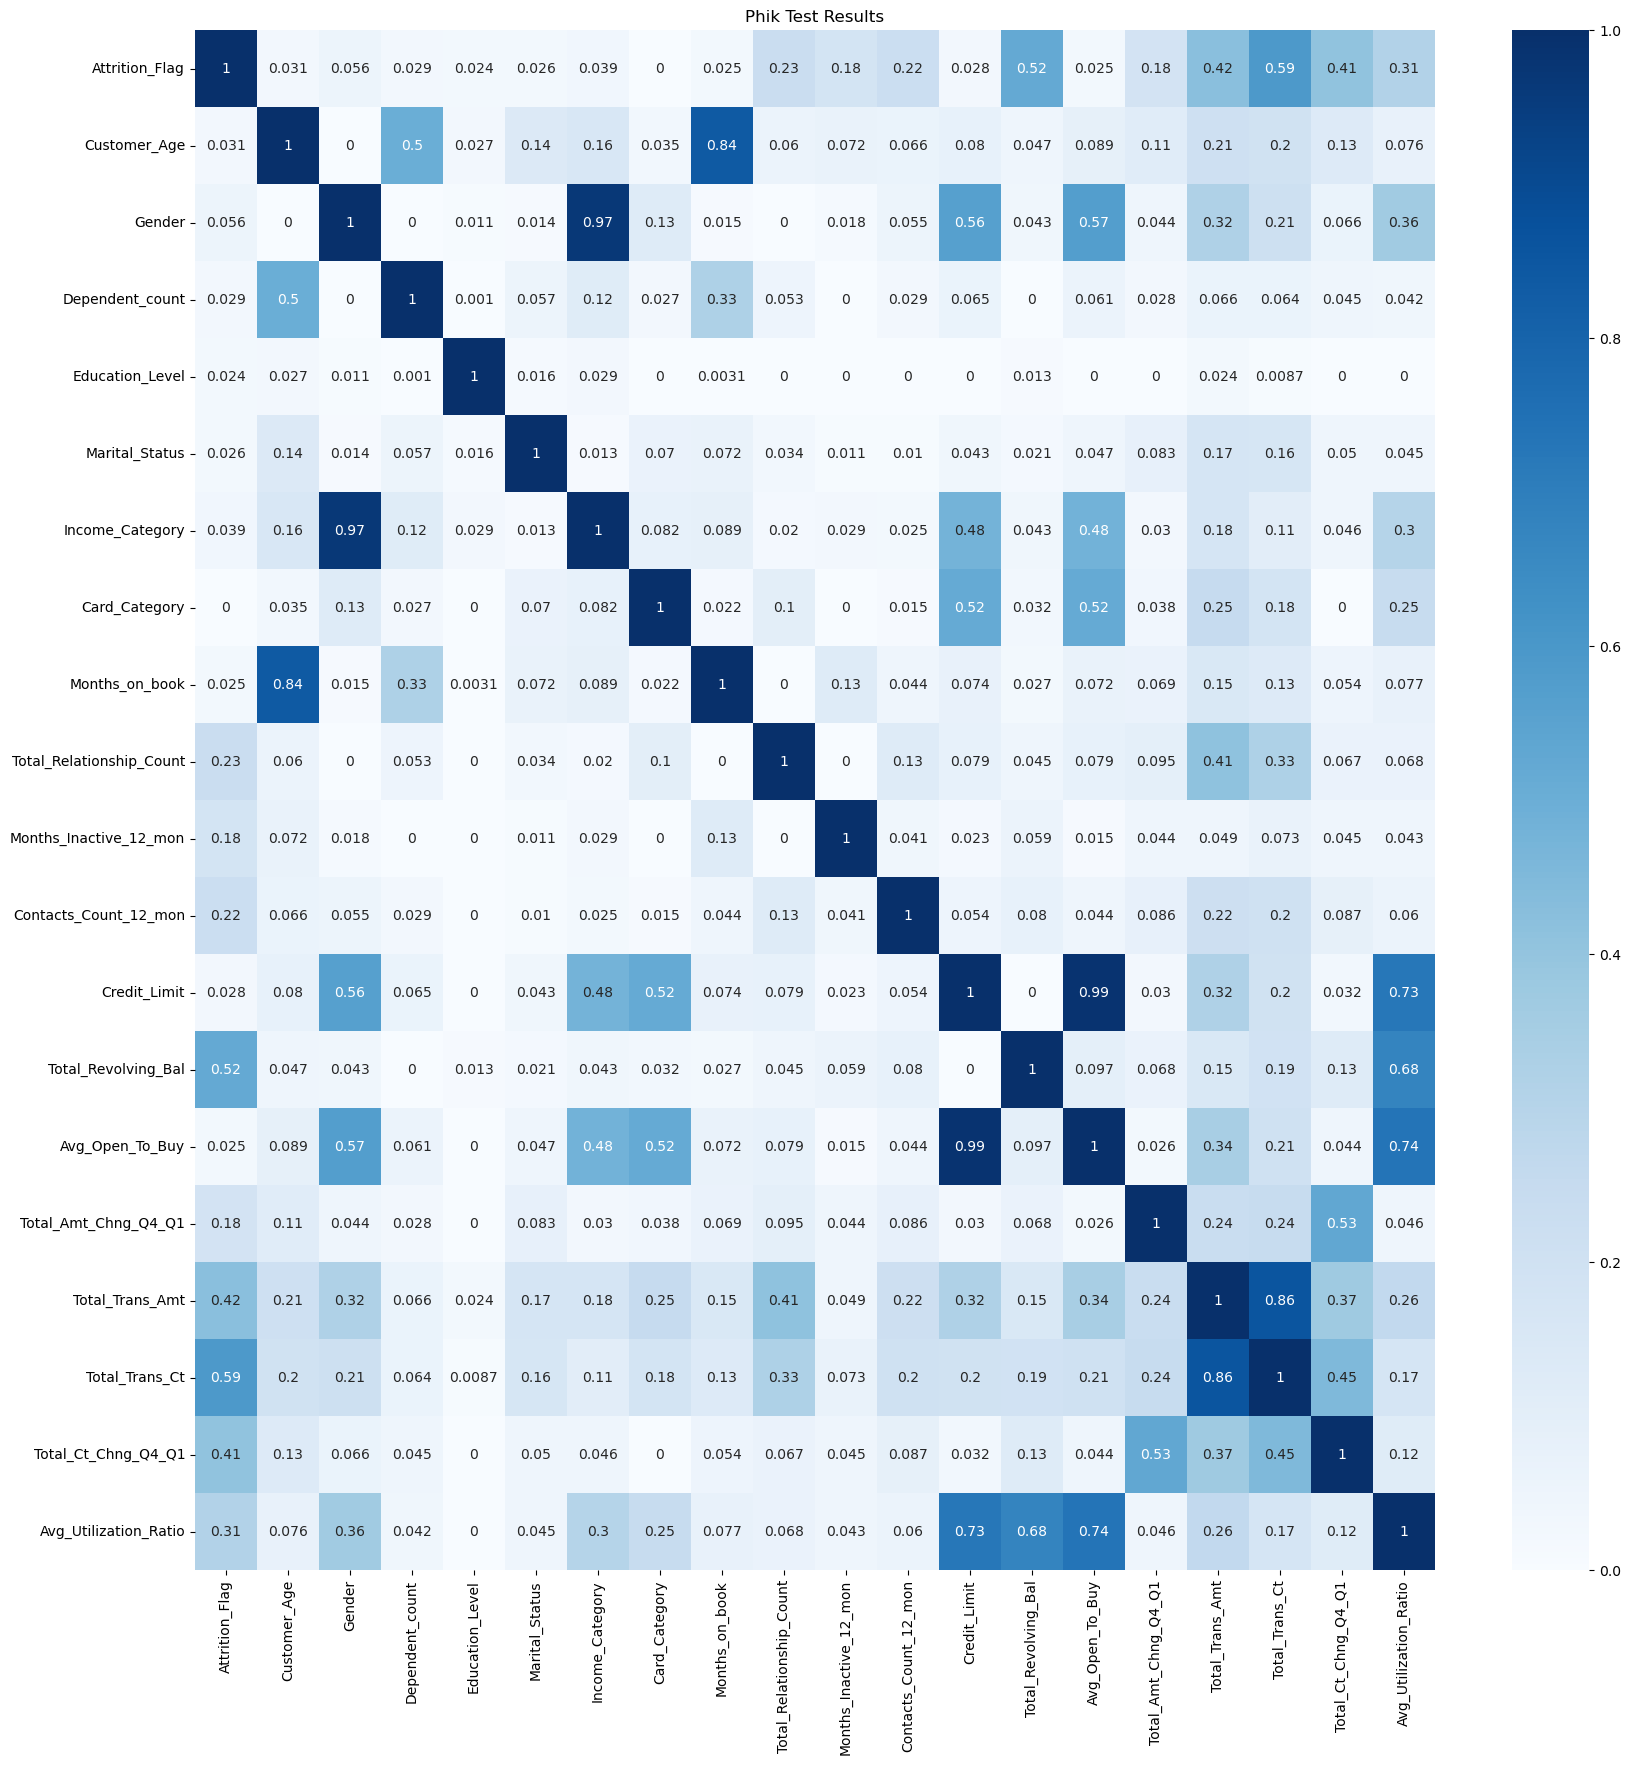

In [32]:
result = df.phik_matrix()

fig = plt.figure(figsize=(20,20))
sns.heatmap(result, annot=True, cmap='Blues')
plt.title('Phik Test Results')
plt.show()

interval columns not set, guessing: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


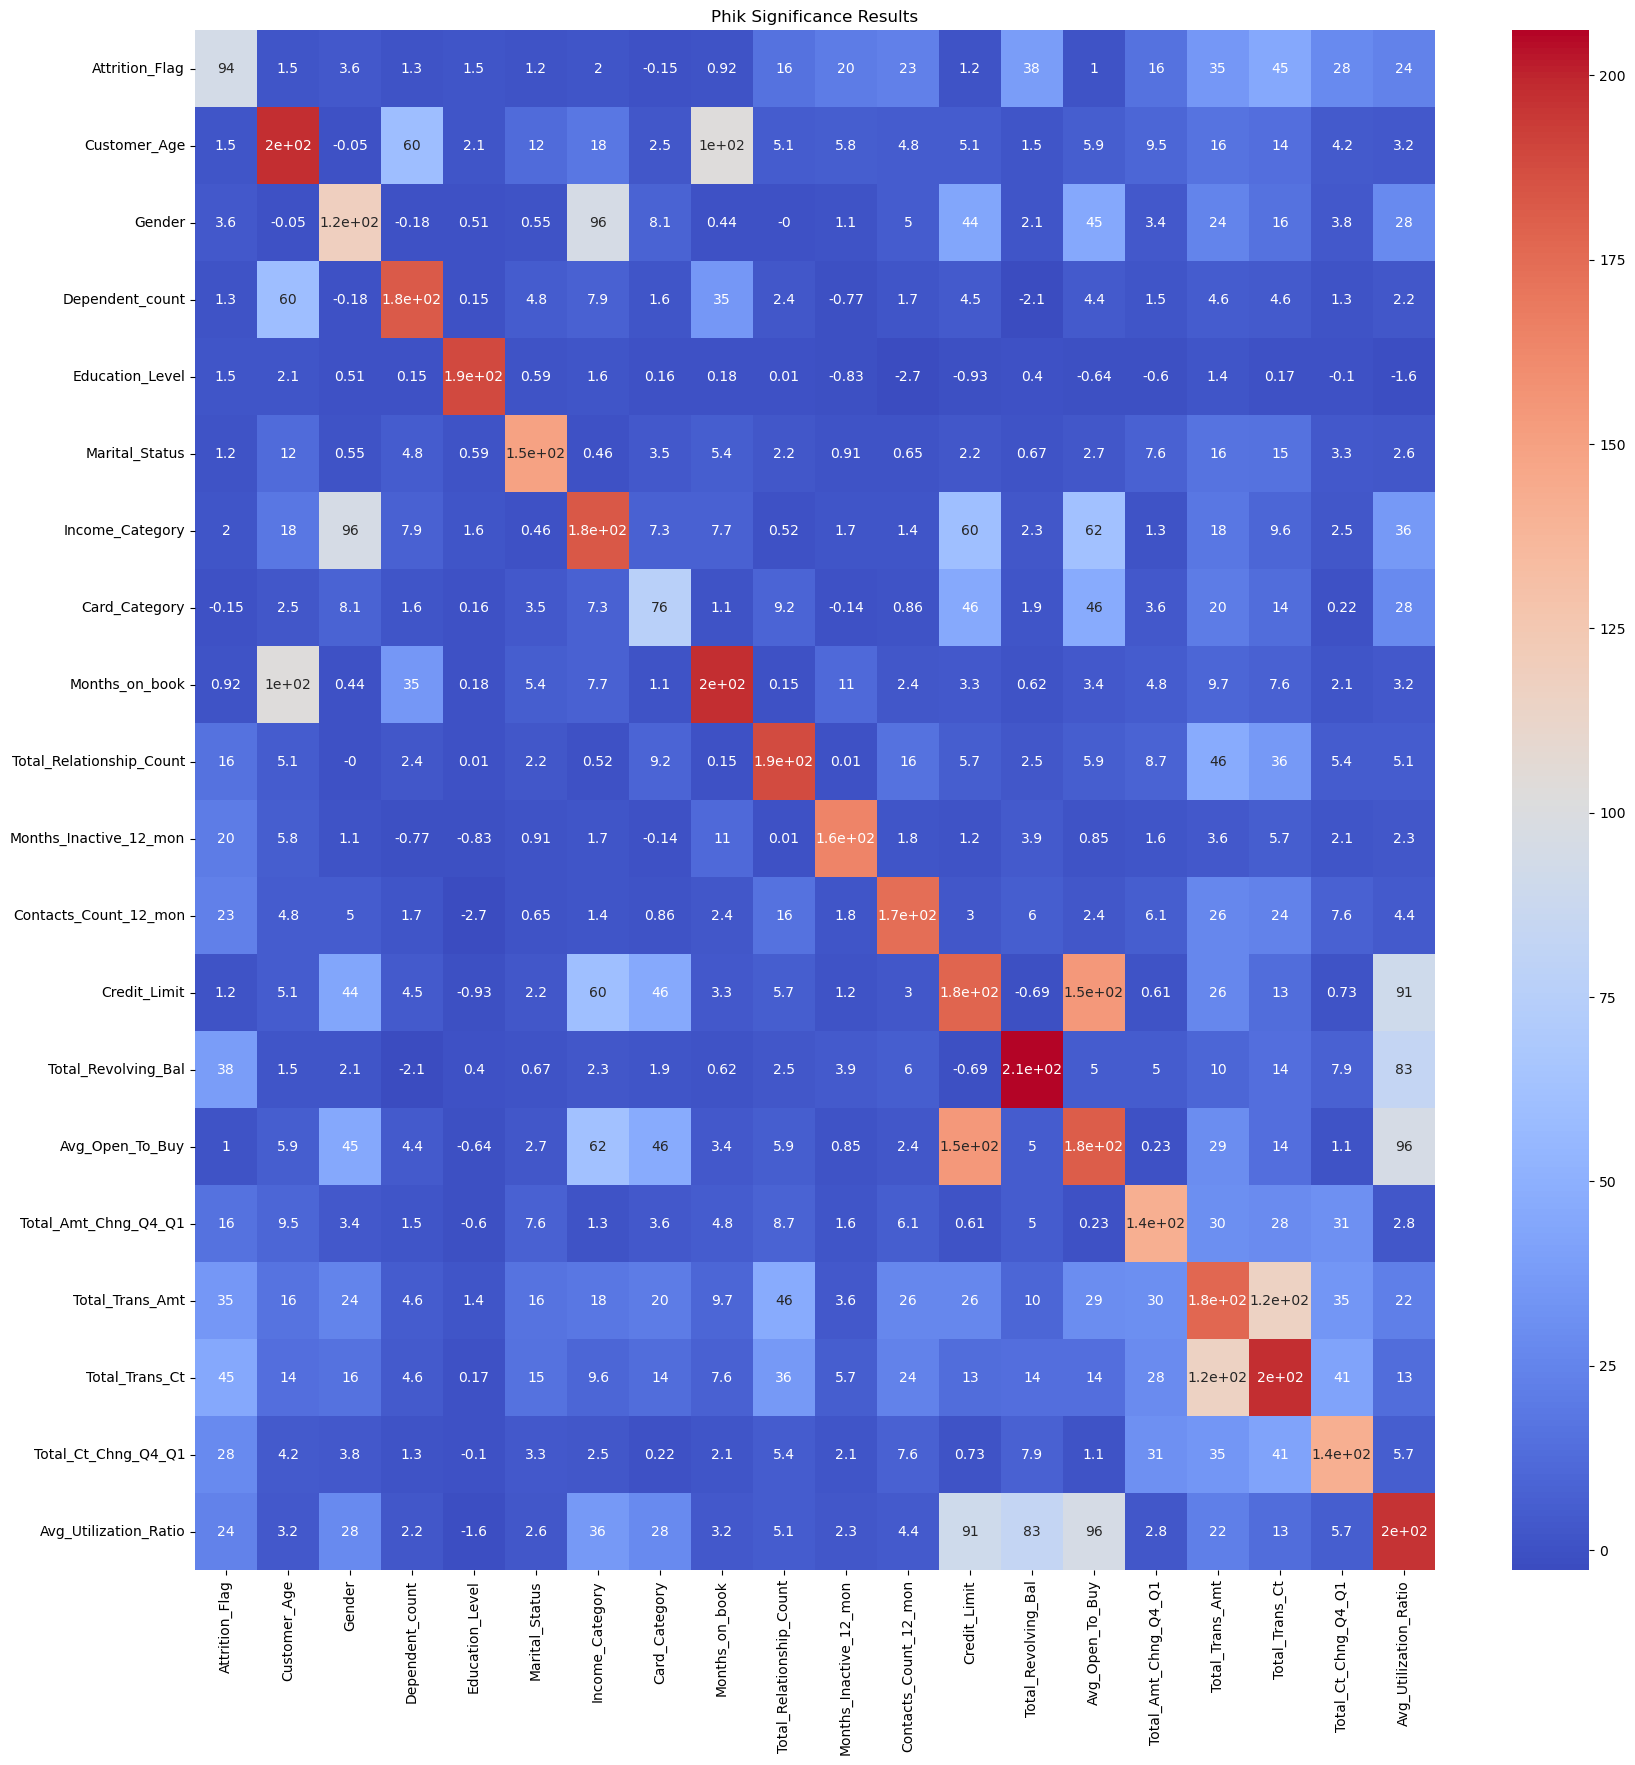

In [49]:
sig = df.significance_matrix()
fig = plt.figure(figsize=(20,20))
sns.heatmap(round(sig,2), annot=True, cmap='coolwarm')
plt.title('Phik Significance Results')
plt.show()

**The high correlations of 3 pairs of features observed with Pearson's r are also shown in phiK analysis**
Besides those, 'Income_Category' and 'Gender' are highly correlated (phik 0.97). I will choose 'Income_Category' for clustering


### Feature engineering

In [33]:
# drop the highly correlated features: 'Avg_Open_To_Buy', 'Customer_Age', 'Gender', 'Attrition_Flag'
new_df = df.drop(columns=['Avg_Open_To_Buy', 'Customer_Age', 'Gender', 'Attrition_Flag'])

In [35]:
# generate 2 new feature average transaction amount (Total_trans_amt/Total_trans_ct), 
# average transaction amount change Q4_Q1 (Total_Amt_chng_Q4_Q1/Total_Ct_Chng_Q4_Q1)
new_df['Avg_Trans_Amt'] = df['Total_Trans_Amt']/df['Total_Trans_Ct']
new_df['Avg_Amt_Chng_Q4_Q1'] = df['Total_Amt_Chng_Q4_Q1']/df['Total_Ct_Chng_Q4_Q1']

In [36]:
new_df.head()

Dependent_count Education_Level Marital_Status Income_Category  \
0                3     High School        Married     $60K - $80K   
1                5        Graduate         Single  Less than $40K   
2                3        Graduate        Married    $80K - $120K   
3                4     High School        Unknown  Less than $40K   
4                3      Uneducated        Married     $60K - $80K   

  Card_Category  Months_on_book  Total_Relationship_Count  \
0          Blue              39                         5   
1          Blue              44                         6   
2          Blue              36                         4   
3          Blue              34                         3   
4          Blue              21                         5   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                       1                      3       12691.0   
1                       1                      2        8256.0   
2                       1                      0        3418.0   
3                       4                      1        3313.0   
4                       1                      0        4716.0   

   Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0                  777                 1.335             1144              42   
1                  864                 1.541             1291              33   
2                    0                 2.594             1887              20   
3                 2517                 1.405             1171              20   
4                    0                 2.175              816              28   

   Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  Avg_Trans_Amt  \
0                1.625                  0.061      27.238095   
1                3.714                  0.105      39.121212   
2                2.333                  0.000      94.350000   
3                2.333                  0.760      58.550000   
4                2.500                  0.000      29.142857   

   Avg_Amt_Chng_Q4_Q1  
0            0.821538  
1            0.414917  
2            1.111873  
3            0.602229  
4            0.870000

Text(0.5, 1.0, 'Pearson correlation Results')

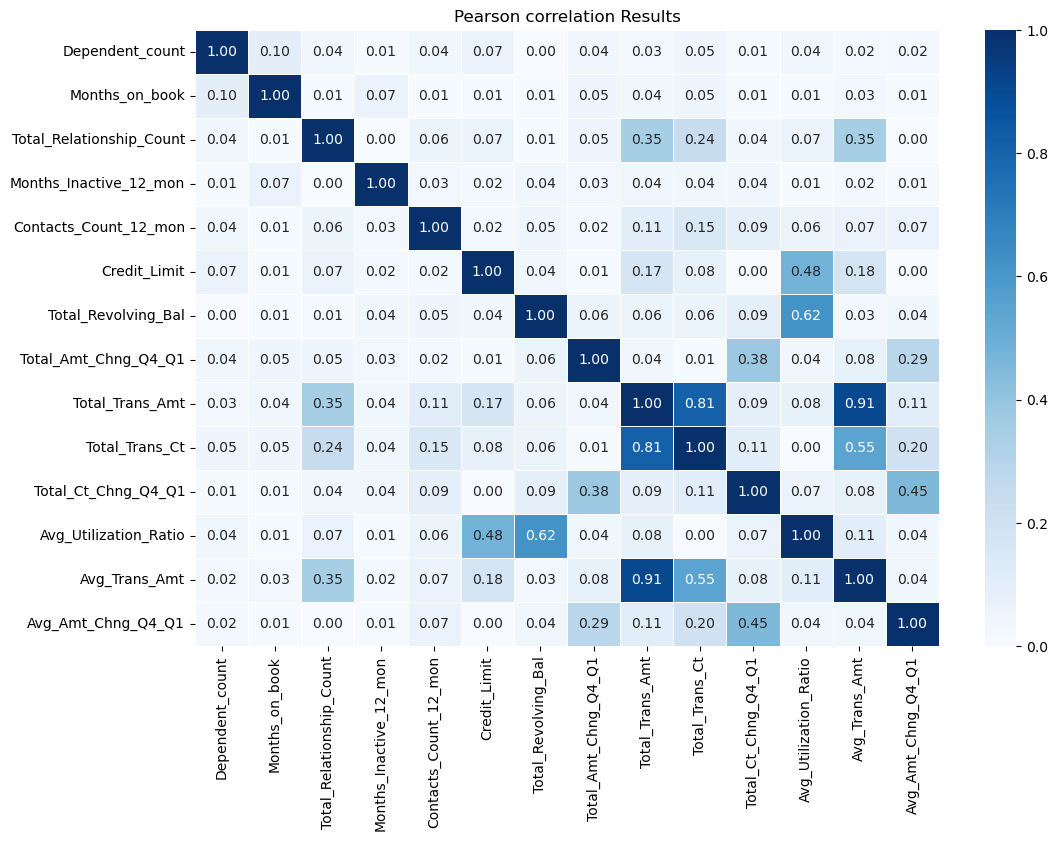

In [37]:
# Pearson correlation with absolute values
plt.figure(figsize=(12,8))
sns.heatmap(abs(round(new_df.corr(),2)), 
#             vmin=-1.0, 
#             vmax=1.0, 
            linewidths=0.5, 
            cmap='Blues', 
            annot=True, 
            fmt='.2f')
plt.title('Pearson correlation Results')

interval columns not set, guessing: ['Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Avg_Trans_Amt', 'Avg_Amt_Chng_Q4_Q1']


invalid value encountered in multiply


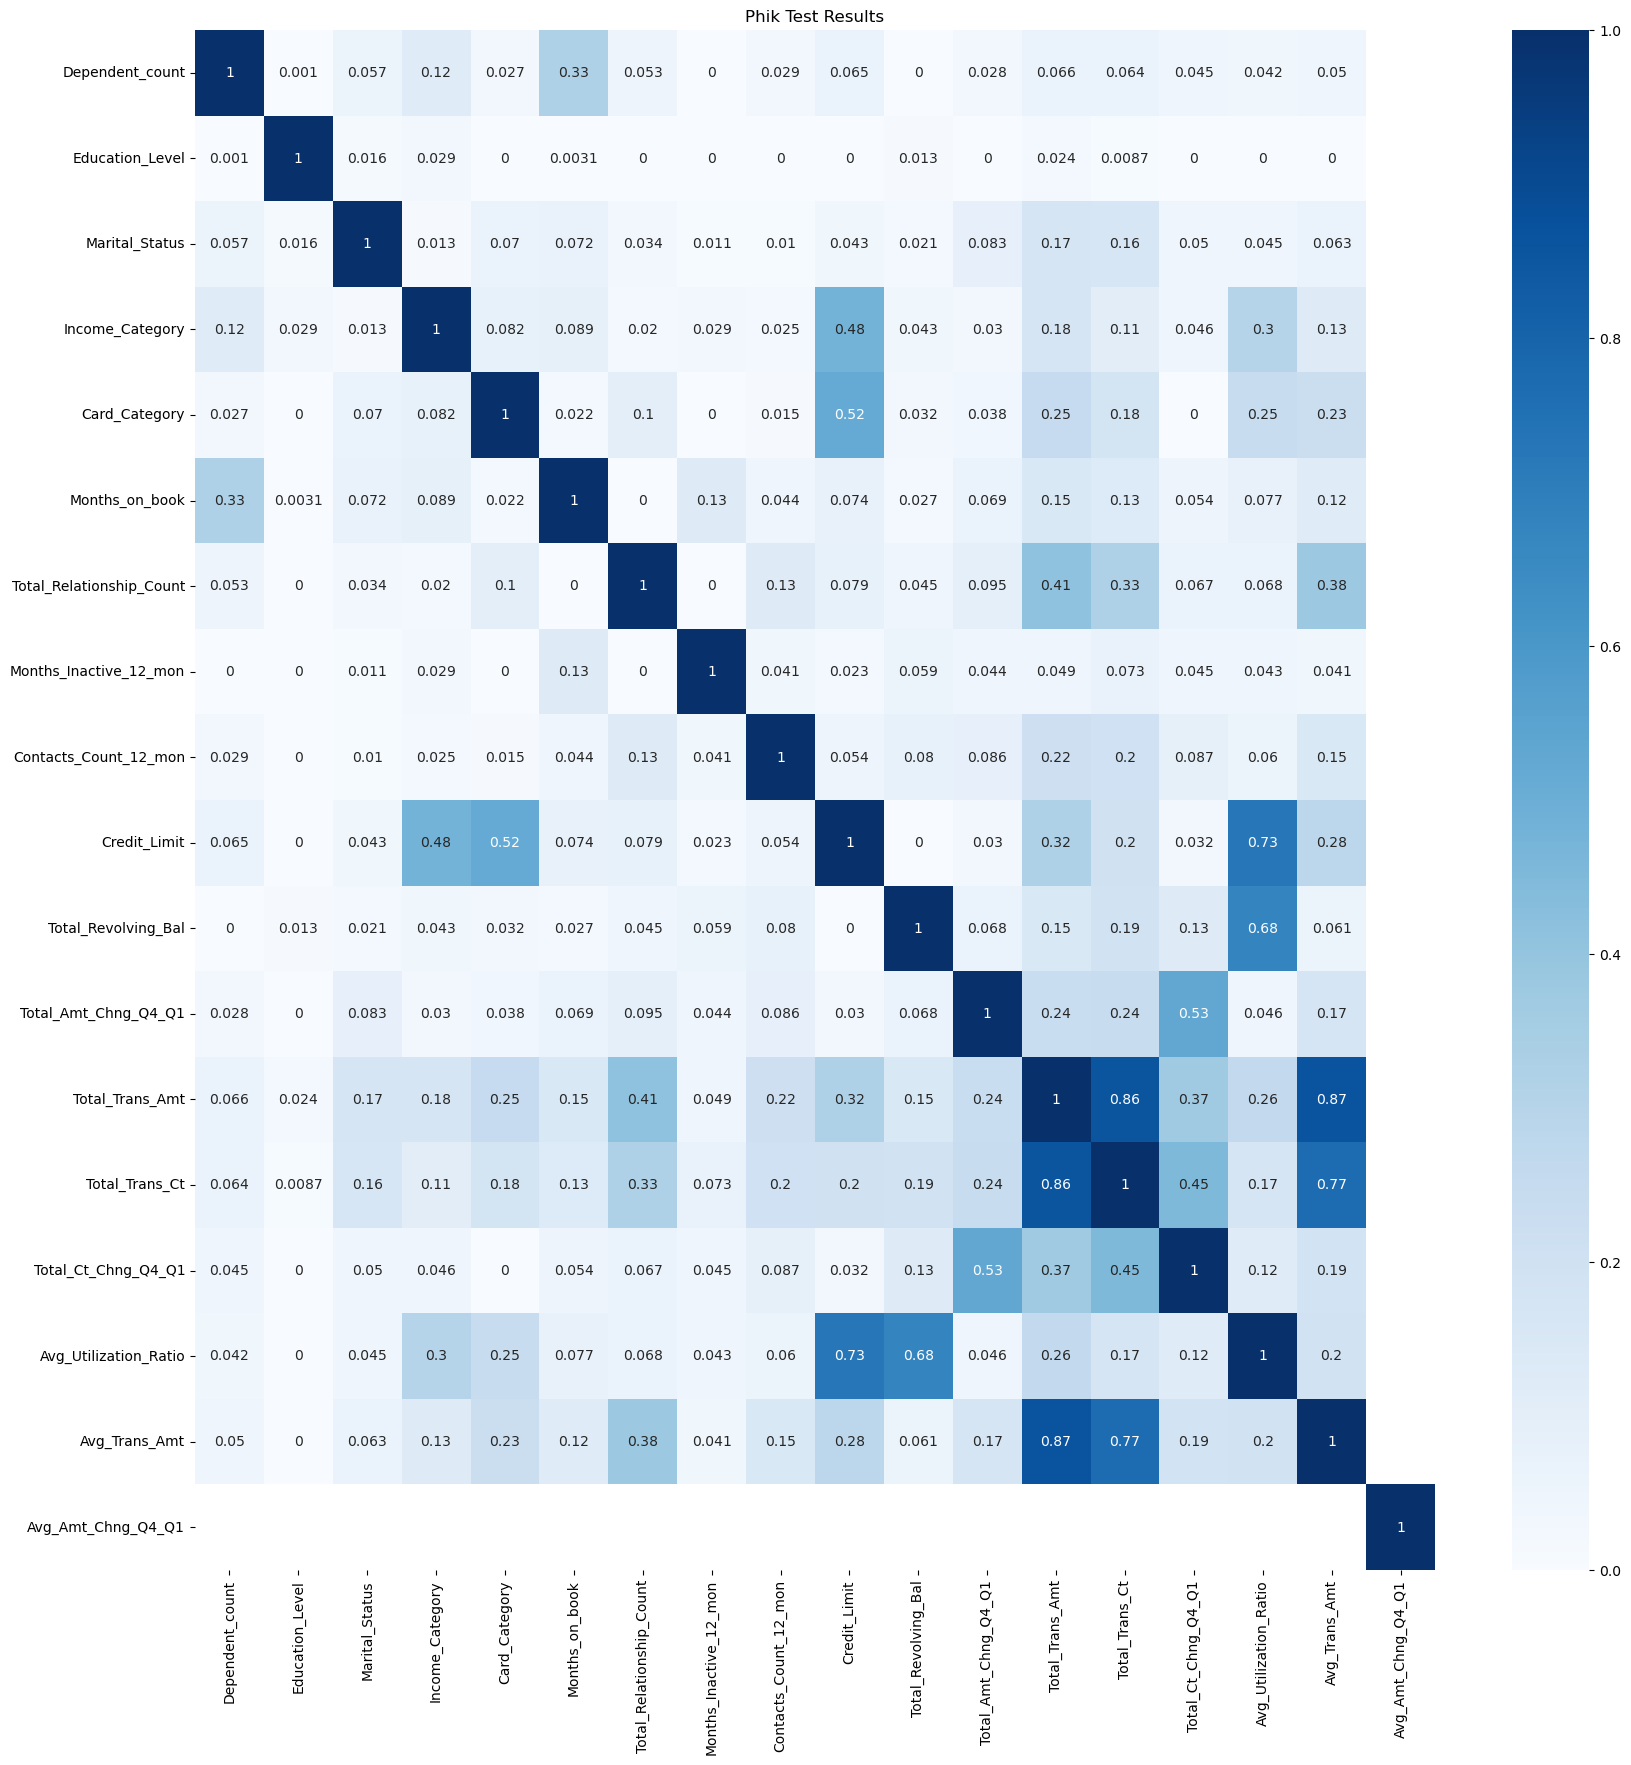

In [39]:
result = new_df.phik_matrix()

fig = plt.figure(figsize=(20,20))
sns.heatmap(result, annot=True, cmap='Blues')
plt.title('Phik Test Results')
plt.show()

In [42]:
new_df.columns

Index(['Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
       'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Avg_Trans_Amt',
       'Avg_Amt_Chng_Q4_Q1'],
      dtype='object')

**New features don't contribute to correlations. I decided to not include any new features for clustering. (Total_Trans_Amt and Total_Ct are highly correlated (0.86). I will use Total_Trans_Ct and drop Total_trans_Amt??**

In [44]:
new_df.drop(columns=['Avg_Trans_Amt', 'Avg_Amt_Chng_Q4_Q1', 'Total_Trans_Amt'], inplace=True)

In [50]:
# save new_df for clustering
new_df.to_csv('raw_data_clustering.csv', index=False)

## Data preprocessing

**There are no missing values in numerical features. Unknown data in 'Education_Level','Marital_Status','Income_Category'. I will treat the unknown as a category.**

**learning kprototype links**
https://zachary-a-zazueta.medium.com/k-prototypes-clustering-for-when-youre-clustering-continuous-and-categorical-data-6ea42c2ab2b9


1. Behavioral data in new_df will be power-transformed to achieved Guasian-like distribution, and 0-centered and unit normalized. They will be used for KMean and KPrototypes clustering
2. demographic data in new_df will be oneHot encoded. I will try two combinations for Kprototype: raw demographic data + transformed behavioral, oneHot demographic data +transformed behavioral

In [ ]:
# read in new_data for clustering
# new_df = pd.read_csv('raw_data_clustering.csv')

# seperate demogrpahic and behavioral columns in new_df
demo_sub = [col for col in new_df.columns if col in demo_cols]
behave_sub = [col for col in new_df.columns if col in behave_cols]

In [59]:
print(demo_sub)

['Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


In [60]:
print(behave_sub)

['Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


#### Transform behavioral columns

In [61]:
behave_df = pd.DataFrame(PowerTransformer().fit_transform(new_df[behave_sub]), columns=behave_sub)
behave_df.head()

Months_on_book  Total_Relationship_Count  Months_Inactive_12_mon  \
0        0.371128                  0.762305               -1.458324   
1        1.015094                  1.417080               -1.458324   
2       -0.009129                  0.112803               -1.458324   
3       -0.259895                 -0.530415                1.525554   
4       -1.827473                  0.762305               -1.458324   

   Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0               0.495883      0.962782            -0.003768   
1              -0.406084      0.566512             0.076214   
2              -2.246757     -0.416953            -1.666149   
3              -1.318361     -0.456520             1.114008   
4              -2.246757     -0.028788            -1.666149   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0              2.259377       -0.964211             3.016295   
1              2.803534       -1.397079             6.011005   
2              4.654269       -2.078301             4.359489   
3              2.454134       -2.078301             4.359489   
4              4.056715       -1.649743             4.612643   

   Avg_Utilization_Ratio  
0              -0.768027  
1              -0.497366  
2              -1.201678  
3               1.484731  
4              -1.201678

In [76]:
# save the behavioral to csv
behave_df.to_csv('sub_behave_df_powerTransformed.csv', index=False)

#### Raw demo columns in new_df

In [67]:
raw_demo_df = new_df[demo_sub].copy()
raw_demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Dependent_count  10127 non-null  int64 
 1   Education_Level  10127 non-null  object
 2   Marital_Status   10127 non-null  object
 3   Income_Category  10127 non-null  object
 4   Card_Category    10127 non-null  object
dtypes: int64(1), object(4)
memory usage: 395.7+ KB


In [69]:
## 'Dependent_count' is int64, need to be transformed to categorical 
raw_demo_df.loc[:,'Dependent_count'] = pd.Categorical(raw_demo_df.loc[:,'Dependent_count'])
raw_demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Dependent_count  10127 non-null  category
 1   Education_Level  10127 non-null  object  
 2   Marital_Status   10127 non-null  object  
 3   Income_Category  10127 non-null  object  
 4   Card_Category    10127 non-null  object  
dtypes: category(1), object(4)
memory usage: 326.7+ KB


In [70]:
raw_demo_df.head()

Dependent_count Education_Level Marital_Status Income_Category Card_Category
0               3     High School        Married     $60K - $80K          Blue
1               5        Graduate         Single  Less than $40K          Blue
2               3        Graduate        Married    $80K - $120K          Blue
3               4     High School        Unknown  Less than $40K          Blue
4               3      Uneducated        Married     $60K - $80K          Blue

In [77]:
# save raw_demo df to csv
raw_demo_df.to_csv('sub_raw_demo_df.csv', index=False)

#### OneHot encode demo columns 

In [71]:
# create the oneHot encoded categorical data with dtype int32 
# get_dummies can transform all selected columns at once
oneHot_demo = pd.get_dummies(raw_demo_df, dtype='int32') 
# save oneHot_data to csv
oneHot_demo.to_csv("oneHot_demo_sub.csv", index=False)

In [72]:
oneHot_demo.shape

(10127, 27)

In [75]:
oneHot_demo.head()

Dependent_count_0  Dependent_count_1  Dependent_count_2  Dependent_count_3  \
0                  0                  0                  0                  1   
1                  0                  0                  0                  0   
2                  0                  0                  0                  1   
3                  0                  0                  0                  0   
4                  0                  0                  0                  1   

   Dependent_count_4  Dependent_count_5  Education_Level_College  \
0                  0                  0                        0   
1                  0                  1                        0   
2                  0                  0                        0   
3                  1                  0                        0   
4                  0                  0                        0   

   Education_Level_Doctorate  Education_Level_Graduate  \
0                          0                         0   
1                          0                         1   
2                          0                         1   
3                          0                         0   
4                          0                         0   

   Education_Level_High School  ...  Income_Category_$120K +  \
0                            1  ...                        0   
1                            0  ...                        0   
2                            0  ...                        0   
3                            1  ...                        0   
4                            0  ...                        0   

   Income_Category_$40K - $60K  Income_Category_$60K - $80K  \
0                            0                            1   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            1   

   Income_Category_$80K - $120K  Income_Category_Less than $40K  \
0                             0                               0   
1                             0                               1   
2                             1                               0   
3                             0                               1   
4                             0                               0   

   Income_Category_Unknown  Card_Category_Blue  Card_Category_Gold  \
0                        0                   1                   0   
1                        0                   1                   0   
2                        0                   1                   0   
3                        0                   1                   0   
4                        0                   1                   0   

   Card_Category_Platinum  Card_Category_Silver  
0                       0                     0  
1                       0                     0  
2                       0                     0  
3                       0                     0  
4                       0                     0  

[5 rows x 27 columns]

## use Kprototypes in Kmodes for clustering both cat and num viarables

In [2]:
# read in data sets
behave_df = pd.read_csv('sub_behave_df_powerTransformed.csv')
raw_demo_df = pd.read_csv('sub_raw_demo_df.csv')
oneHot_demo = pd.read_csv("oneHot_demo_sub.csv")

In [3]:
oneHot_demo.head()

Dependent_count_0  Dependent_count_1  Dependent_count_2  Dependent_count_3  \
0                  0                  0                  0                  1   
1                  0                  0                  0                  0   
2                  0                  0                  0                  1   
3                  0                  0                  0                  0   
4                  0                  0                  0                  1   

   Dependent_count_4  Dependent_count_5  Education_Level_College  \
0                  0                  0                        0   
1                  0                  1                        0   
2                  0                  0                        0   
3                  1                  0                        0   
4                  0                  0                        0   

   Education_Level_Doctorate  Education_Level_Graduate  \
0                          0                         0   
1                          0                         1   
2                          0                         1   
3                          0                         0   
4                          0                         0   

   Education_Level_High School  ...  Income_Category_$120K +  \
0                            1  ...                        0   
1                            0  ...                        0   
2                            0  ...                        0   
3                            1  ...                        0   
4                            0  ...                        0   

   Income_Category_$40K - $60K  Income_Category_$60K - $80K  \
0                            0                            1   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            1   

   Income_Category_$80K - $120K  Income_Category_Less than $40K  \
0                             0                               0   
1                             0                               1   
2                             1                               0   
3                             0                               1   
4                             0                               0   

   Income_Category_Unknown  Card_Category_Blue  Card_Category_Gold  \
0                        0                   1                   0   
1                        0                   1                   0   
2                        0                   1                   0   
3                        0                   1                   0   
4                        0                   1                   0   

   Card_Category_Platinum  Card_Category_Silver  
0                       0                     0  
1                       0                     0  
2                       0                     0  
3                       0                     0  
4                       0                     0  

[5 rows x 27 columns]

In [5]:
# combine demo and behave data
oneHot_behave = pd.concat([oneHot_demo, behave_df], axis=1)
demo_behave = pd.concat([raw_demo_df, behave_df], axis=1)
demo_behave['Dependent_count'] = demo_behave['Dependent_count'].astype('O')

In [6]:
demo_behave.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Dependent_count           10127 non-null  object 
 1   Education_Level           10127 non-null  object 
 2   Marital_Status            10127 non-null  object 
 3   Income_Category           10127 non-null  object 
 4   Card_Category             10127 non-null  object 
 5   Months_on_book            10127 non-null  float64
 6   Total_Relationship_Count  10127 non-null  float64
 7   Months_Inactive_12_mon    10127 non-null  float64
 8   Contacts_Count_12_mon     10127 non-null  float64
 9   Credit_Limit              10127 non-null  float64
 10  Total_Revolving_Bal       10127 non-null  float64
 11  Total_Amt_Chng_Q4_Q1      10127 non-null  float64
 12  Total_Trans_Ct            10127 non-null  float64
 13  Total_Ct_Chng_Q4_Q1       10127 non-null  float64
 14  Avg_Ut

In [9]:
# get the indice of categorical columns in two data sets
oneHot_cat_cols = [i for i, col in enumerate(oneHot_behave.columns) if oneHot_behave[col].dtype == 'int64']
print('Categorical columns of oneHot_behave are:', oneHot_behave.columns[oneHot_cat_cols])

raw_cat_cols = [i for i, col in enumerate(demo_behave.columns) if demo_behave[col].dtype == 'O']
print('Categorical columns of demo_behave are:', demo_behave.columns[raw_cat_cols])

Categorical columns of oneHot_behave are: Index(['Dependent_count_0', 'Dependent_count_1', 'Dependent_count_2',
       'Dependent_count_3', 'Dependent_count_4', 'Dependent_count_5',
       'Education_Level_College', 'Education_Level_Doctorate',
       'Education_Level_Graduate', 'Education_Level_High School',
       'Education_Level_Post-Graduate', 'Education_Level_Uneducated',
       'Education_Level_Unknown', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Unknown', 'Income_Category_$120K +',
       'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K',
       'Income_Category_$80K - $120K', 'Income_Category_Less than $40K',
       'Income_Category_Unknown', 'Card_Category_Blue', 'Card_Category_Gold',
       'Card_Category_Platinum', 'Card_Category_Silver'],
      dtype='object')
Categorical columns of demo_behave are: Index(['Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Categ

In [10]:
# apply kprototype on demo_behave (with raw categorical data)
# elbow plot to find best number of clusters

raw_costs= []
raw_n_clusters = []
raw_clusters_assigned = []
# scores = []
raw_dMatrix = demo_behave.to_numpy() # convert to numpy array for model

for i in range(2,15):
    try:
        kproto = KPrototypes(n_clusters = i, init='Cao', verbose=2, n_jobs=-1)
        clusters = kproto.fit_predict(raw_dMatrix, categorical=raw_cat_cols) # clarify index of categorical features
        raw_costs.append(kproto.cost_)
        raw_n_clusters.append(i)
        raw_clusters_assigned.append(clusters)
#         scores.append(silhouette_score(raw_dMatrix, clusters, metric='euclidean'))
    except:
        print(f"Can't cluster with {i} clusters")


Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 8
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 8
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 8
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 8
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 9
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 9
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 10
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 3
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 9
Initialization meth

Text(0, 0.5, 'Cost')

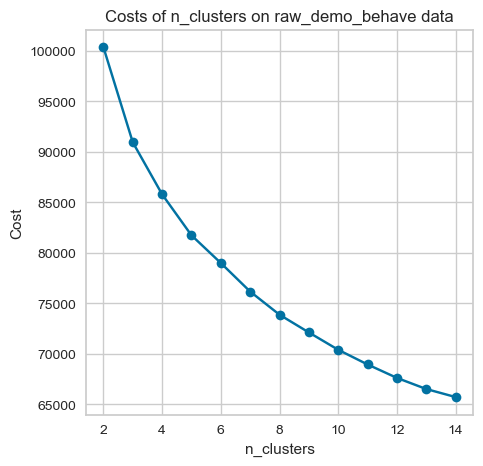

In [11]:
# plot out cost and Silhouette score
fig, ax1 = plt.subplots(figsize=(5,5))
# elbow plot
ax1.plot(raw_n_clusters, raw_costs, 'o-')
ax1.set_title('Costs of n_clusters on raw_demo_behave data')
ax1.set_xlabel('n_clusters')
ax1.set_ylabel('Cost')


In [20]:
# apply kprototype on oneHot_behave (with oneHot encoded categorical data)
# elbow plot to find best number of clusters

oneHot_costs= []
oneHot_n_clusters = []
oneHot_clusters_assigned = []
oneHot_scores = []
oneHot_dMatrix = oneHot_behave.to_numpy() # convert to numpy array for model

for i in range(2,15):
    try:
        kproto = KPrototypes(n_clusters = i, init='Cao', verbose=2, n_jobs=-1, random_state=42)
        clusters = kproto.fit_predict(oneHot_dMatrix, categorical=oneHot_cat_cols) # clarify index of categorical features
        oneHot_costs.append(kproto.cost_)
        oneHot_n_clusters.append(i)
        oneHot_clusters_assigned.append(clusters)
        oneHot_scores.append(silhouette_score(oneHot_dMatrix, clusters, metric='euclidean'))
    except:
        print(f"Can't cluster with {i} clusters")

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 3
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 10
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 10
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 6
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 6
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 8
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 8
Initialization met

Text(0, 0.5, 'Silhouette score')

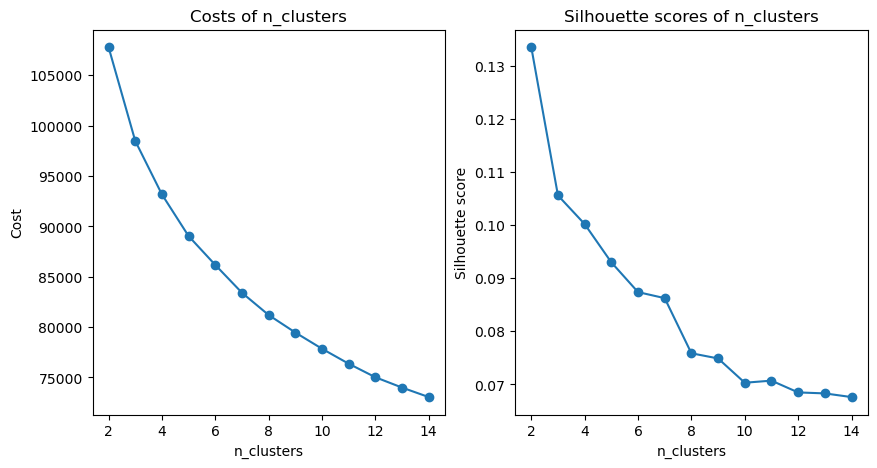

In [24]:
# plot out cost and Silhouette score
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
# elbow plot
ax1.plot(oneHot_n_clusters, oneHot_costs, 'o-')
ax1.set_title('Costs of n_clusters')
ax1.set_xlabel('n_clusters')
ax1.set_ylabel('Cost')

ax2.plot(oneHot_n_clusters, oneHot_scores, 'o-')
ax2.set_title('Silhouette scores of n_clusters')
ax2.set_xlabel('n_clusters')
ax2.set_ylabel('Silhouette score')

**The difference between using oneHot encoded categorical and raw categorical features are:**
1. Calculation time: It takes longer time for KPrototype to fit in oneHot encoded dataset
2. The cost of each clustering with same n_cluster: The costs on oneHot encoded data are larger
Conclusion: Using Kprototype with raw categorical data and transformed numerical features is recommended.

In [28]:
# I choose n_clusters = 7 for visualization
kproto = KPrototypes(n_clusters=7, init='Cao', n_jobs=-1, verbose=2, random_state=42)
kp_clusters = kproto.fit_predict(raw_dMatrix, categorical=raw_cat_cols)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 6


In [17]:
# Cluster centorid
# kproto.cluster_centroids_
# Check the iteration of the clusters created
# kproto.n_iter_
# Check the cost of the clusters created
kproto.cost_

76202.82814785684

In [150]:
## use n-cluster =7 for kproto
kproto = KPrototypes(n_clusters=7, init='Cao', n_jobs=-1, verbose=2, random_state=42)
kproto.fit_predict(kproto_data, categorical=categorical_cols)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 4


array([4, 4, 4, ..., 5, 5, 2], dtype=uint16)

In [ ]:
kp_clusters = kproto.labels_

### Kmeans on behavioral data

In [23]:
# try elbow method for optimal K
wcss = []
score = []

for i in range(2,16):
    km = KMeans(n_clusters = i,init = 'k-means++',max_iter = 500,n_init=10,random_state=42)
    #data = StandardScaler().fit_transform(df[behv_col])
    km.fit(behave_df) # behave_df is power transformed
    wcss.append(km.inertia_)
    score.append(silhouette_score(behave_df, km.labels_, metric='euclidean'))


Text(0, 0.5, 'Silhouette score')

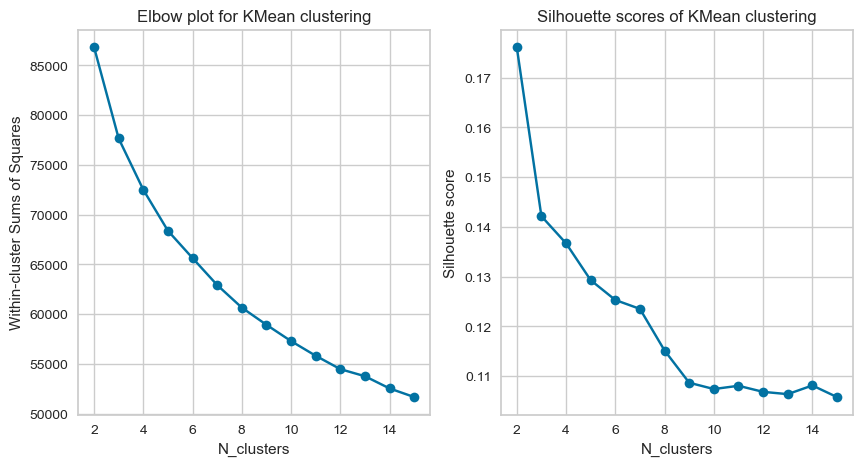

In [24]:
# plot out cost and Silhouette score
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
# elbow plot
ax1.plot(range(2,16), wcss, 'o-')
ax1.set_title('Elbow plot for KMean clustering')
ax1.set_xlabel('N_clusters')
ax1.set_ylabel('Within-cluster Sums of Squares')

ax2.plot(range(2,16), score, 'o-')
ax2.set_title('Silhouette scores of KMean clustering')
ax2.set_xlabel('N_clusters')
ax2.set_ylabel('Silhouette score')

#### Analyzing with Silhouette score

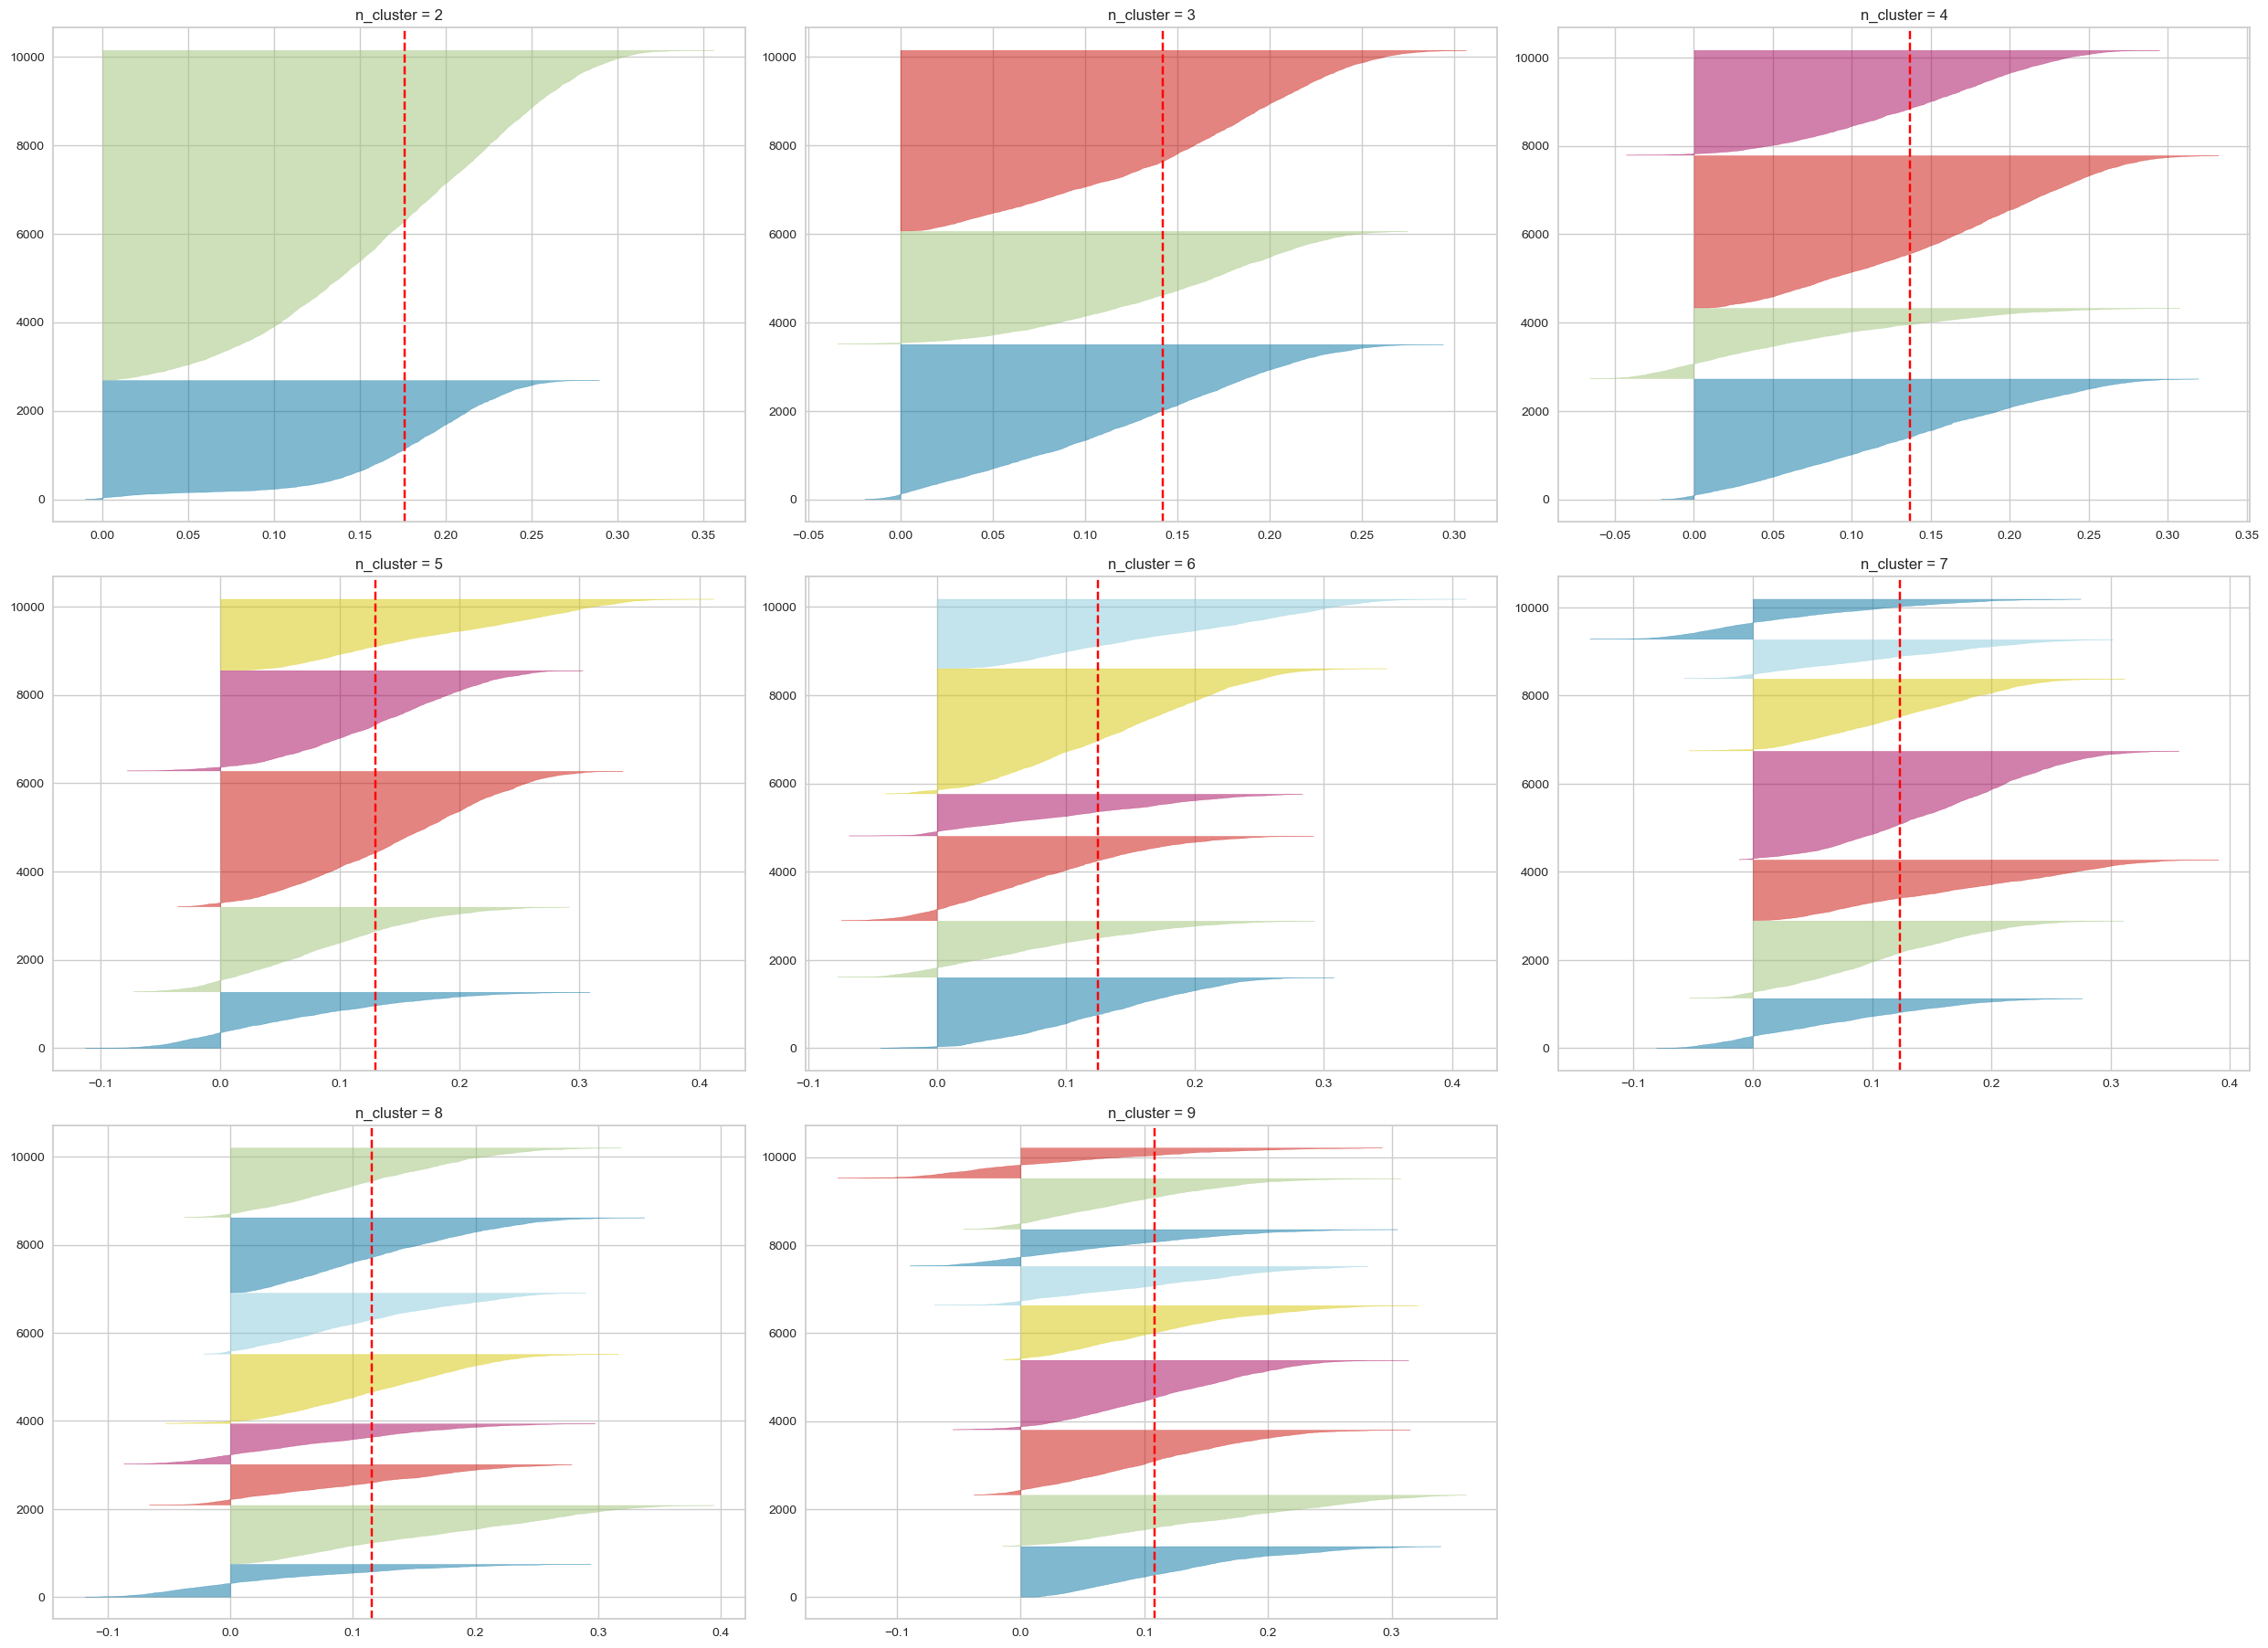

In [20]:
from yellowbrick.cluster import SilhouetteVisualizer
plt.figure(figsize=(25, 30))
for i in [2,3,4,5,6,7,8,9]:
    plt.subplot(5, 3, i-1)    
    #Create KMeans instance for different number of clusters
    km = KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=500,random_state=42)
#     q, mod = divmod(i, 2)
   
    #Create SilhouetteVisualizer instance with KMeans instance. Fit the visualizer
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(behave_df)
    plt.title(f'n_clusters = {i}')
plt.tight_layout()

**Choose n_clusters = 7**

In [25]:
km = KMeans(n_clusters = 7,init = 'k-means++',max_iter = 500,n_init=10,random_state=42)
km.fit(behave_df)
km_clusters = km.labels_

#### Visualization of KMean and KPrototypes clustering results with PCA and T-SNE

In [29]:
# use only behavior data for PCA and T-SNE
pca = PCA(n_components=2, random_state=42)
df_behv_pca = pd.DataFrame(pca.fit_transform(behave_df), 
                           columns=["component_1", "component_2"])
df_behv_pca['km_clusters'] = km_clusters
df_behv_pca['kp_clusters'] = kp_clusters
df_behv_pca.head()

component_1  component_2  km_clusters  kp_clusters
0    -0.564182    -2.405248            6            0
1    -1.983306    -3.624327            6            0
2    -0.885387    -4.183412            6            0
3    -3.301323    -1.703752            6            0
4    -0.889489    -4.445321            6            0

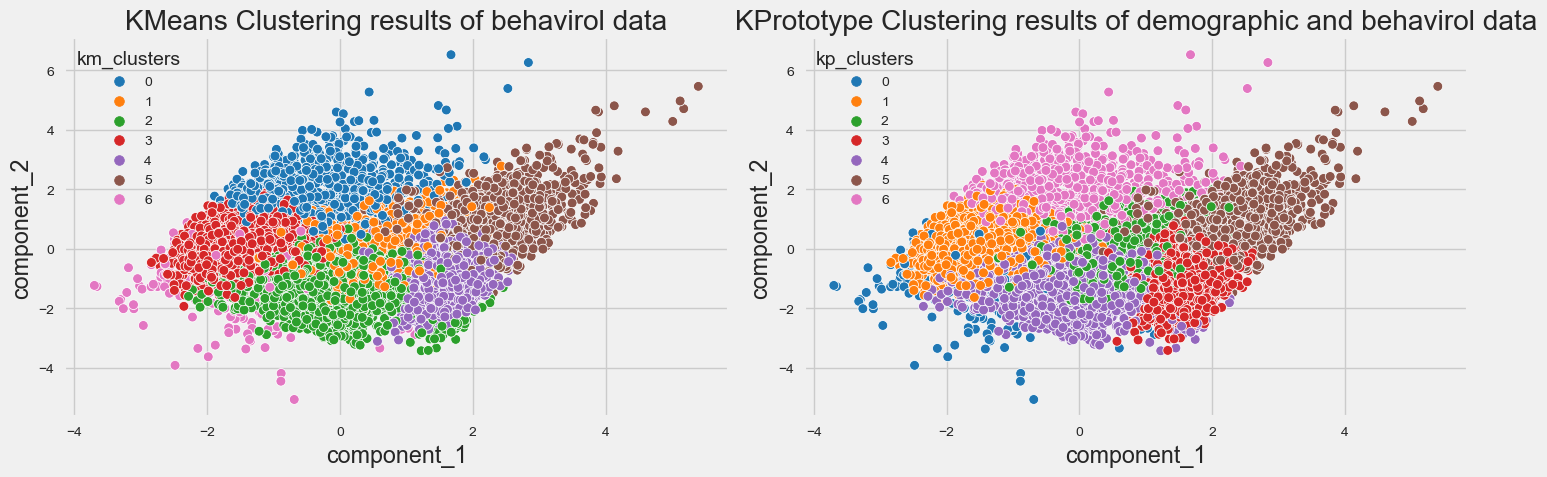

In [39]:
# plot results from two clustering methods
fig, axes = plt.subplots(1,2, figsize=(15,5))
plt.style.use("fivethirtyeight")

sns.scatterplot(
        x="component_1",
        y="component_2",
        s=50,
        data=df_behv_pca,
        hue="km_clusters",
        palette='tab10',
        ax=axes[0]
    )
   
axes[0].set_title(
        "KMeans Clustering results of behavirol data"
    )

sns.scatterplot(
        x="component_1",
        y="component_2",
        s=50,
        data=df_behv_pca,
        hue="kp_clusters",
        palette='tab10',
        ax=axes[1]
    )
   
axes[1].set_title(
        "KPrototype Clustering results of demographic and behavirol data"
    )


# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)   
plt.tight_layout()

#### T-SNE

In [40]:
tsne= TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3,
                  random_state= 42)
df_behv_tsne = pd.DataFrame(tsne.fit_transform(behave_df), 
                           columns=["tsne_component_1", "tsne_component_2"])
df_behv_tsne['km_clusters'] = km_clusters
df_behv_tsne['kp_clusters'] = kp_clusters
df_behv_tsne.head()

tsne_component_1  tsne_component_2  km_clusters  kp_clusters
0        -82.917732         22.625011            6            0
1        -75.307419         19.320723            6            0
2        -78.620087         21.453506            6            0
3        -42.714138         31.223778            6            0
4        -78.623077         21.448977            6            0

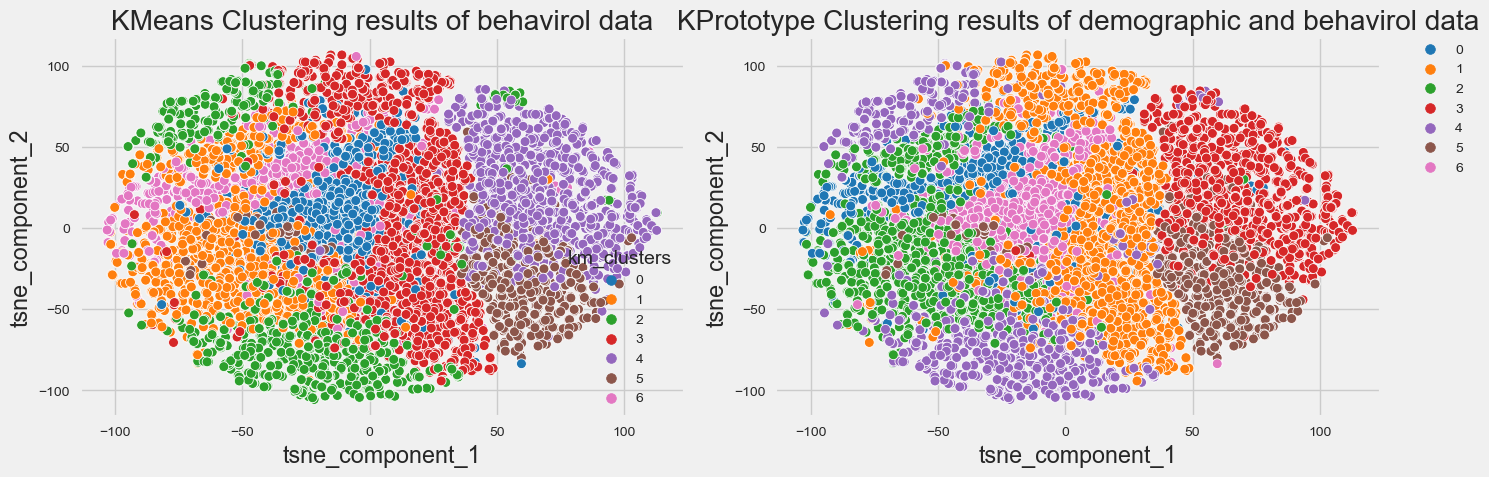

In [42]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
plt.style.use("fivethirtyeight")

sns.scatterplot(
        x="tsne_component_1",
        y="tsne_component_2",
        s=50,
        data=df_behv_tsne,
        hue="km_clusters",
        palette='tab10',
        ax=axes[0]
    )
   
axes[0].set_title(
        "KMeans Clustering results of behavirol data"
    )

sns.scatterplot(
        x="tsne_component_1",
        y="tsne_component_2",
        s=50,
        data=df_behv_tsne,
        hue="kp_clusters",
        palette='tab10',
        ax=axes[1]
    )
   
axes[1].set_title(
        "KPrototype Clustering results of demographic and behavirol data"
    )


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)   
plt.tight_layout()

In [45]:
demo_behave.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Dependent_count           10127 non-null  object 
 1   Education_Level           10127 non-null  object 
 2   Marital_Status            10127 non-null  object 
 3   Income_Category           10127 non-null  object 
 4   Card_Category             10127 non-null  object 
 5   Months_on_book            10127 non-null  float64
 6   Total_Relationship_Count  10127 non-null  float64
 7   Months_Inactive_12_mon    10127 non-null  float64
 8   Contacts_Count_12_mon     10127 non-null  float64
 9   Credit_Limit              10127 non-null  float64
 10  Total_Revolving_Bal       10127 non-null  float64
 11  Total_Amt_Chng_Q4_Q1      10127 non-null  float64
 12  Total_Trans_Ct            10127 non-null  float64
 13  Total_Ct_Chng_Q4_Q1       10127 non-null  float64
 14  Avg_Ut

### Try classifer for the labels from KMeans

In [46]:
#Setting the objects to category 
cat_data = demo_behave.copy()
for i in cat_data.select_dtypes(include='object'):
    cat_data[i] = cat_data[i].astype('category')

In [58]:
# proto_labs = km.labels_
cat_data.columns

Index(['Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Avg_Utilization_Ratio'],
      dtype='object')

In [54]:
clf_km = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_km = cross_val_score(clf_km, cat_data, km_clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_km)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes clusters is 0.8993422767965645


In [55]:
clf_km.fit(cat_data, km_clusters)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree


LGBMClassifier(colsample_by_tree=0.8)

In [56]:
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(cat_data)

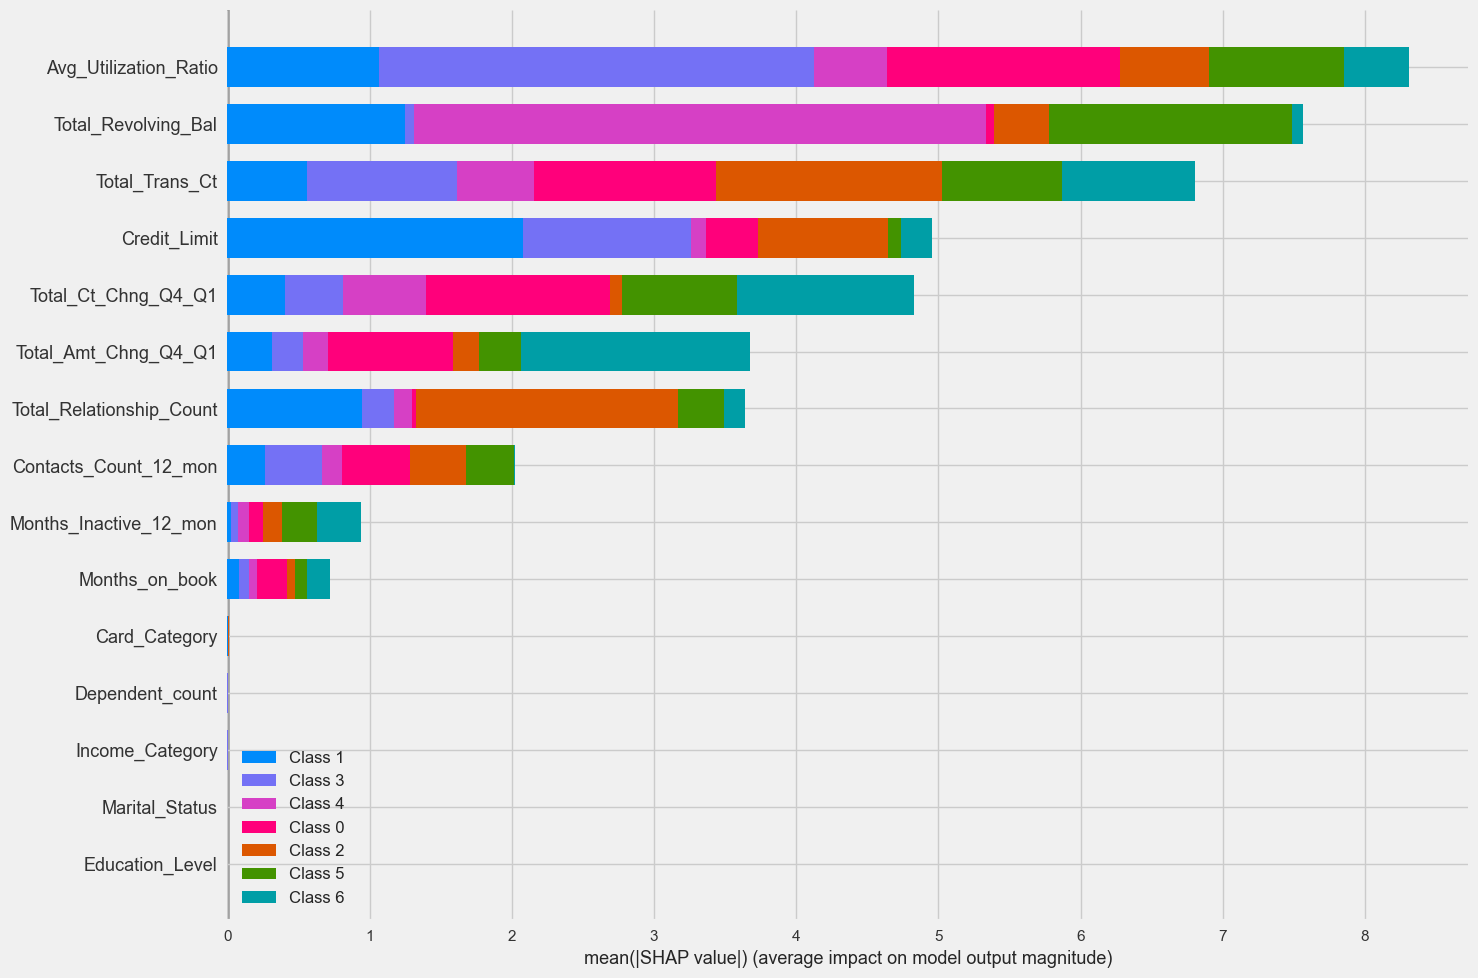

In [57]:
shap.summary_plot(shap_values_km, cat_data, plot_type="bar", plot_size=(15, 10))

### Analysis of clusters

In [73]:
# Because the demographic data do not contribute to clustering, use the cluster from Kmean predication
df_behv_cluster = behave_df.copy()
behave_cols = behave_df.columns
df_behv_cluster['customer_group'] = km_clusters
df_behv_cluster.head()

Months_on_book  Total_Relationship_Count  Months_Inactive_12_mon  \
0        0.371128                  0.762305               -1.458324   
1        1.015094                  1.417080               -1.458324   
2       -0.009129                  0.112803               -1.458324   
3       -0.259895                 -0.530415                1.525554   
4       -1.827473                  0.762305               -1.458324   

   Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0               0.495883      0.962782            -0.003768   
1              -0.406084      0.566512             0.076214   
2              -2.246757     -0.416953            -1.666149   
3              -1.318361     -0.456520             1.114008   
4              -2.246757     -0.028788            -1.666149   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0              2.259377       -0.964211             3.016295   
1              2.803534       -1.397079             6.011005   
2              4.654269       -2.078301             4.359489   
3              2.454134       -2.078301             4.359489   
4              4.056715       -1.649743             4.612643   

   Avg_Utilization_Ratio  customer_group  
0              -0.768027               6  
1              -0.497366               6  
2              -1.201678               6  
3               1.484731               6  
4              -1.201678               6

<AxesSubplot:title={'center':'Segment 7'}>

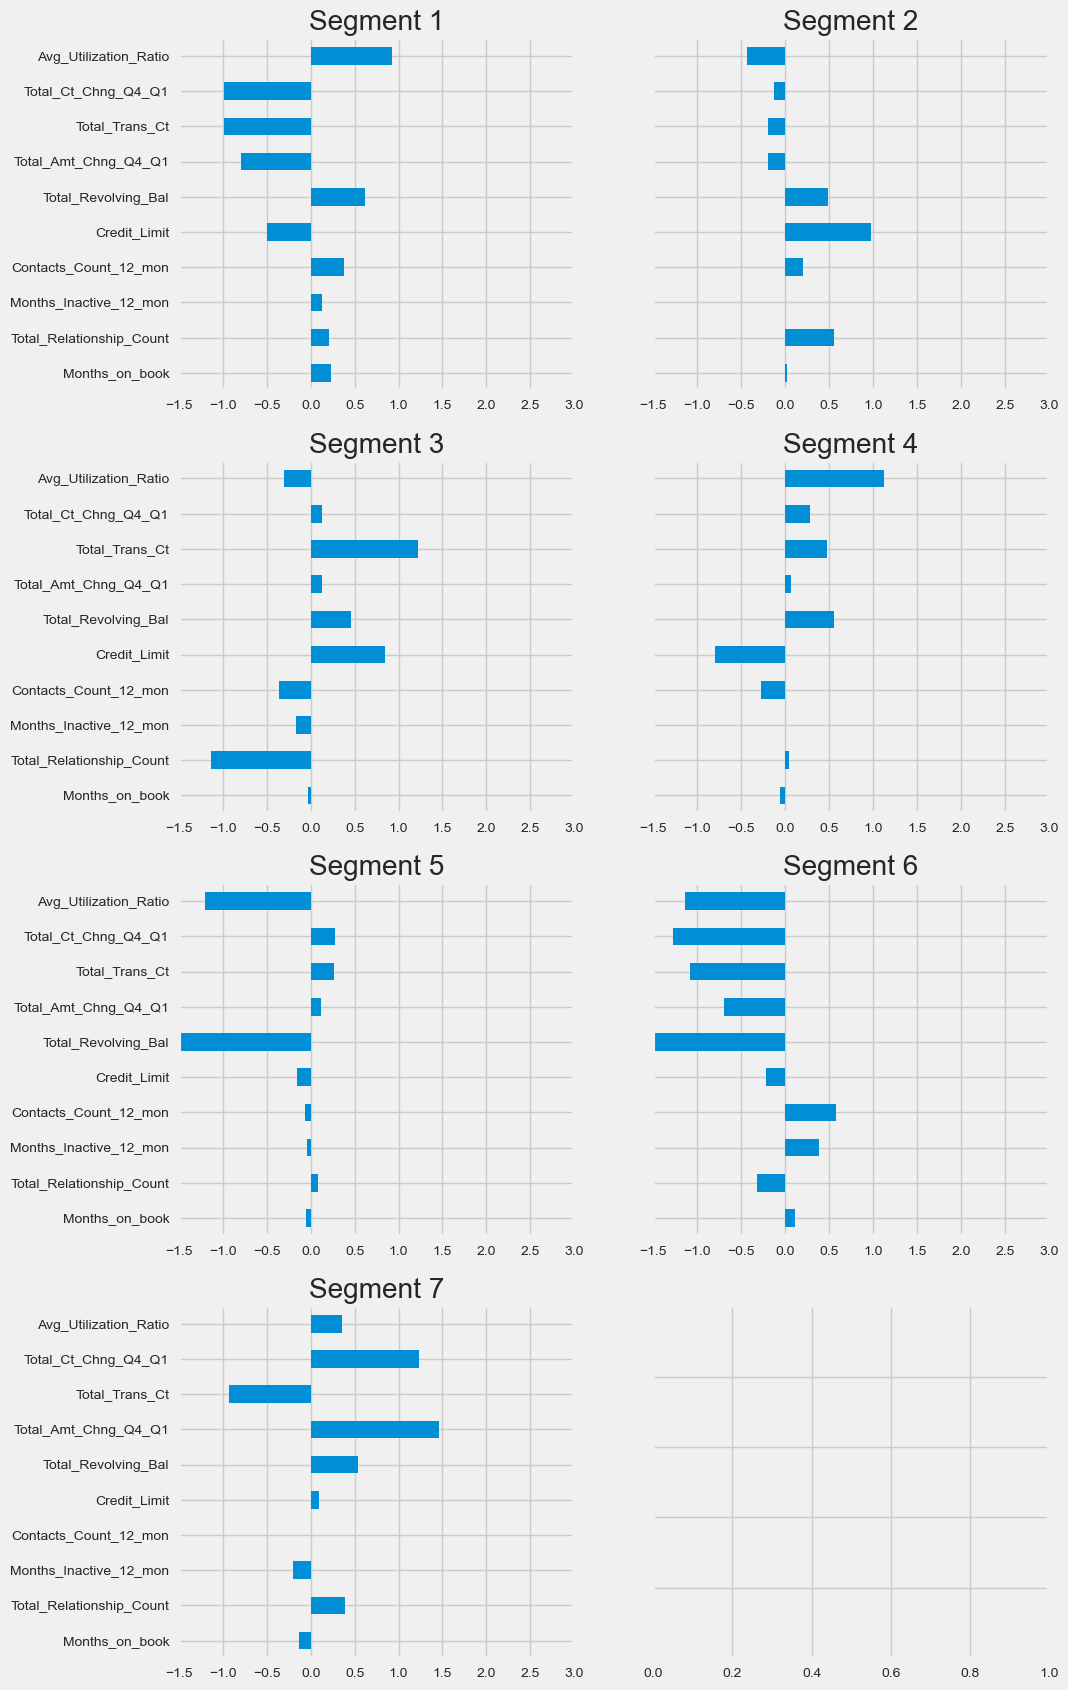

In [74]:
fix, axs = plt.subplots(ncols=2,nrows=4, figsize=(20,32))

df_behv_cluster[df_behv_cluster['customer_group'] == 0][behave_cols].mean().plot.barh(ax=axs[0,0], xlim=(-1.5, 3), figsize=(10,20), sharey=True, title='Segment 1')
df_behv_cluster[df_behv_cluster['customer_group'] == 1][behave_cols].mean().plot.barh(ax=axs[0,1], xlim=(-1.5, 3), figsize=(10,20), sharey=True, title='Segment 2')
df_behv_cluster[df_behv_cluster['customer_group'] == 2][behave_cols].mean().plot.barh(ax=axs[1,0], xlim=(-1.5, 3), figsize=(10,20), sharey=True, title='Segment 3')
df_behv_cluster[df_behv_cluster['customer_group'] == 3][behave_cols].mean().plot.barh(ax=axs[1,1], xlim=(-1.5, 3), figsize=(10,20), sharey=True, title='Segment 4')
df_behv_cluster[df_behv_cluster['customer_group'] == 4][behave_cols].mean().plot.barh(ax=axs[2,0], xlim=(-1.5, 3), figsize=(10,20), sharey=True, title='Segment 5')
df_behv_cluster[df_behv_cluster['customer_group'] == 5][behave_cols].mean().plot.barh(ax=axs[2,1], xlim=(-1.5, 3), figsize=(10,20), sharey=True, title='Segment 6')
df_behv_cluster[df_behv_cluster['customer_group'] == 6][behave_cols].mean().plot.barh(ax=axs[3,0], xlim=(-1.5, 3), figsize=(10,20), sharey=True, title='Segment 7')

### churner percentage in each segment

In [177]:
# percentage churned in each segment
churn = kmCluster_df.groupby(by='km_cluster')['Attrition_Flag'].value_counts(normalize=True)
churn_df = pd.DataFrame()
churn_df['% customers in segment'] = kmCluster_df.groupby(by='km_cluster')['Attrition_Flag'].value_counts(normalize=True)
churn_df.reset_index(inplace=True)
stats_df = churn_df.pivot(index='km_cluster', columns='Attrition_Flag', values='% customers in segment')
stats_df.reset_index(inplace=True)
stats_df = stats_df[['km_cluster', 'Attrited Customer']]

# percentage customer in each segment
tp = pd.DataFrame()
tp['% customers']= kmCluster_df['km_cluster'].value_counts(normalize=True)
tp.reset_index(inplace=True)
tp.rename(columns={'index':"segment"}, inplace=True)

# Merge two df
merged = stats_df.merge(tp, right_on='segment', left_on='km_cluster')
merged['segment'] = merged['segment']+1
merged = merged.rename(columns={'Attrited Customer': '% churned in segment'})
new = merged[['km_cluster','segment', '% customers','% churned in segment']]
new['% customers']= new['% customers'].round(4)*100
new['% churned in segment']= new['% churned in segment'].round(4)*100
print('information of segments')
print(new)

information of segments
   km_cluster  segment  % customers  % churned in segment
0           0        1        11.13                 30.70
1           1        2        17.29                  8.22
2           2        3        13.55                  4.45
3           3        4        24.26                  2.36
4           4        5        16.09                 17.13
5           5        6         8.71                 80.16
6           6        7         8.98                  3.52


In [183]:
kmCluster_df.groupby(by='km_cluster')['Attrition_Flag'].value_counts()

km_cluster  Attrition_Flag   
0           Existing Customer     781
            Attrited Customer     346
1           Existing Customer    1607
            Attrited Customer     144
2           Existing Customer    1311
            Attrited Customer      61
3           Existing Customer    2399
            Attrited Customer      58
4           Existing Customer    1350
            Attrited Customer     279
5           Attrited Customer     707
            Existing Customer     175
6           Existing Customer     877
            Attrited Customer      32
Name: Attrition_Flag, dtype: int64

In [185]:
kmCluster_df[kmCluster_df['km_cluster']==5]['Attrition_Flag'].value_counts()

Attrited Customer    707
Existing Customer    175
Name: Attrition_Flag, dtype: int64

In [162]:
new

segment  % customers  % churned in segment
0        0        11.13                 30.70
1        1        17.29                  8.22
2        2        13.55                  4.45
3        3        24.26                  2.36
4        4        16.09                 17.13
5        5         8.71                 80.16
6        6         8.98                  3.52

#### Demographic information of segments

###### Age

[Text(0.5, 1.0, 'Segment 7'), Text(0, 0.5, ''), Text(0.5, 0, '')]

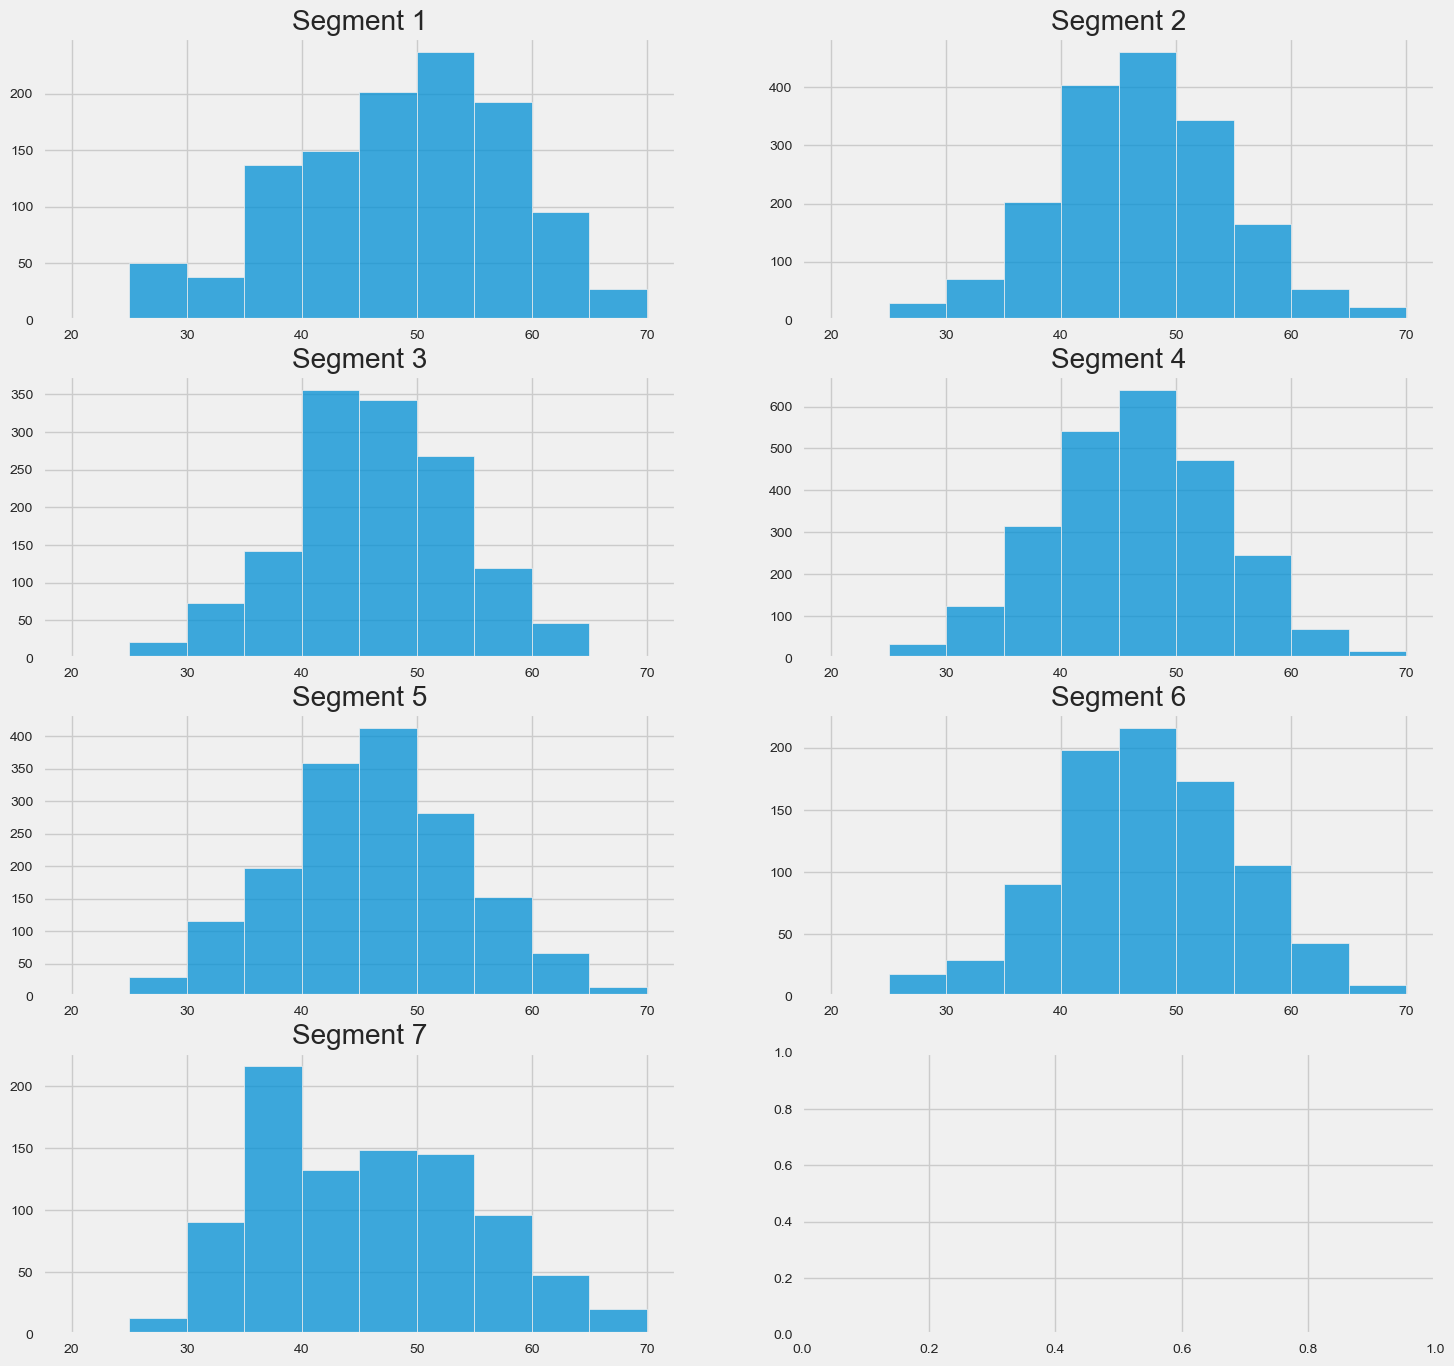

In [166]:
fig, axs = plt.subplots(ncols=2,nrows=4, figsize=(16,16))

sns.histplot(df[df_behv_cluster['customer_group'] == 0]['Customer_Age'], ax=axs[0,0], binrange=(20,70), binwidth=5).set(title='Segment 1', ylabel='', xlabel='')
sns.histplot(df[df_behv_cluster['customer_group'] == 1]['Customer_Age'], ax=axs[0,1], binrange=(20,70), binwidth=5).set(title='Segment 2', ylabel='', xlabel='')
sns.histplot(df[df_behv_cluster['customer_group'] == 2]['Customer_Age'], ax=axs[1,0], binrange=(20,70), binwidth=5).set(title='Segment 3', ylabel='', xlabel='')
sns.histplot(df[df_behv_cluster['customer_group'] == 3]['Customer_Age'], ax=axs[1,1], binrange=(20,70), binwidth=5).set(title='Segment 4', ylabel='', xlabel='')
sns.histplot(df[df_behv_cluster['customer_group'] == 4]['Customer_Age'], ax=axs[2,0], binrange=(20,70), binwidth=5).set(title='Segment 5', ylabel='', xlabel='')
sns.histplot(df[df_behv_cluster['customer_group'] == 5]['Customer_Age'], ax=axs[2,1], binrange=(20,70), binwidth=5).set(title='Segment 6', ylabel='', xlabel='')
sns.histplot(df[df_behv_cluster['customer_group'] == 6]['Customer_Age'], ax=axs[3,0], binrange=(20,70), binwidth=5).set(title='Segment 7', ylabel='', xlabel='')

##### Gender

<AxesSubplot:title={'center':'Segment 7'}>

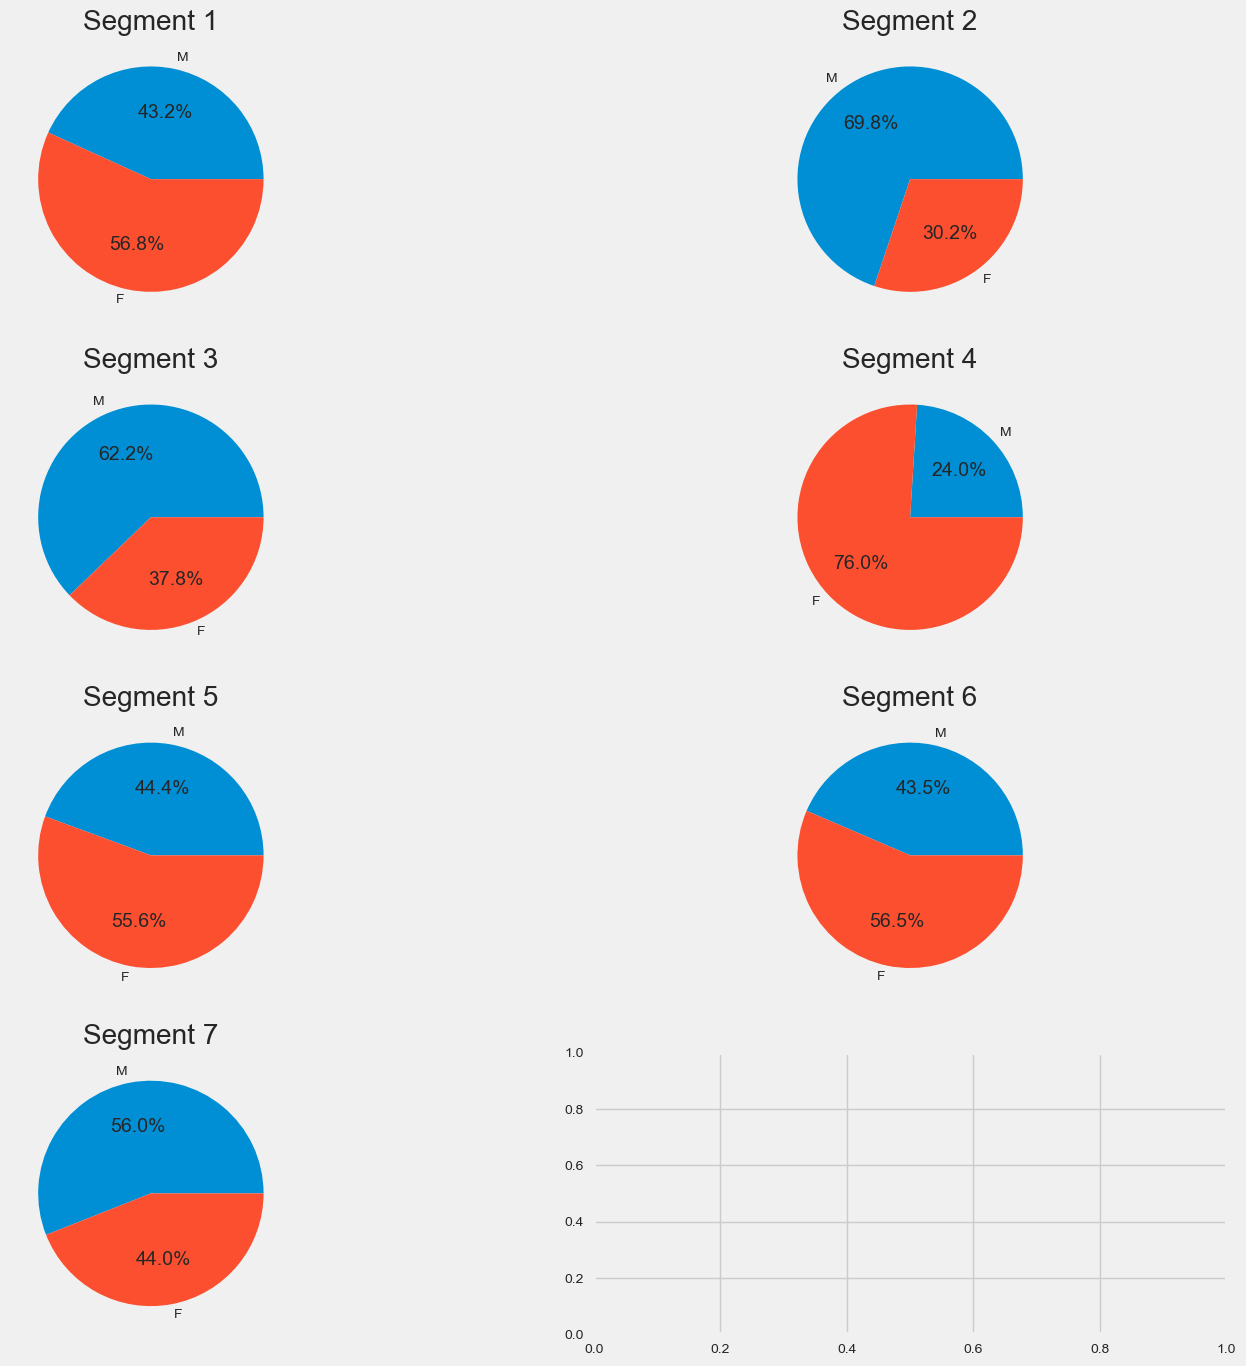

In [167]:
fix, axs = plt.subplots(ncols=2,nrows=4, figsize=(16,16))

df[df_behv_cluster['customer_group'] == 0]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[0,0], ylabel='', title='Segment 1', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 1]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[0,1], ylabel='', title='Segment 2', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 2]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[1,0], ylabel='', title='Segment 3', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 3]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[1,1], ylabel='', title='Segment 4', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 4]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[2,0], ylabel='', title='Segment 5', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 5]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[2,1], ylabel='', title='Segment 6', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 6]['Gender'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[3,0], ylabel='', title='Segment 7', autopct='%.1f%%')

##### Number of dependents

<AxesSubplot:title={'center':'Segment 7'}>

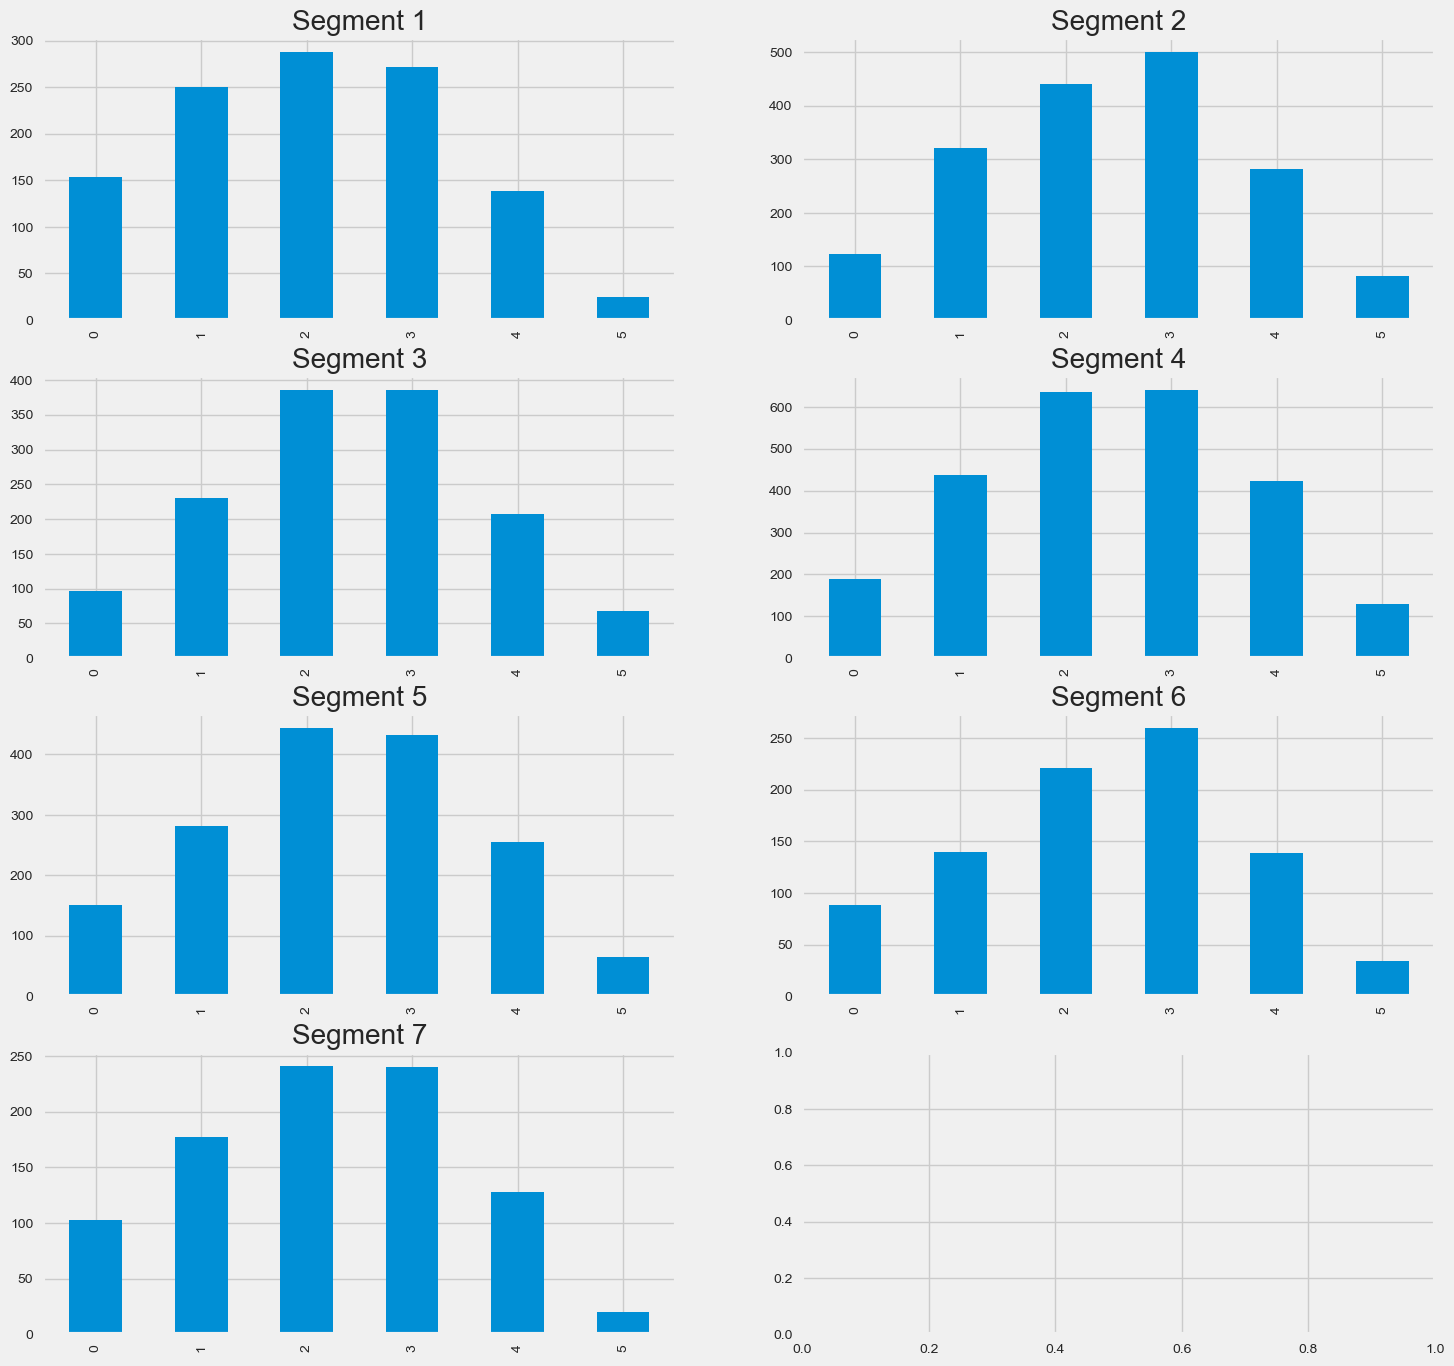

In [172]:
fix, axs = plt.subplots(ncols=2,nrows=4, figsize=(16,16))

df[df_behv_cluster['customer_group'] == 0]['Dependent_count'].value_counts().sort_index().plot.bar(ax=axs[0,0], title='Segment 1')
df[df_behv_cluster['customer_group'] == 1]['Dependent_count'].value_counts().sort_index().plot.bar(ax=axs[0,1], title='Segment 2')
df[df_behv_cluster['customer_group'] == 2]['Dependent_count'].value_counts().sort_index().plot.bar(ax=axs[1,0], title='Segment 3')
df[df_behv_cluster['customer_group'] == 3]['Dependent_count'].value_counts().sort_index().plot.bar(ax=axs[1,1], title='Segment 4')
df[df_behv_cluster['customer_group'] == 4]['Dependent_count'].value_counts().sort_index().plot.bar(ax=axs[2,0], title='Segment 5')
df[df_behv_cluster['customer_group'] == 5]['Dependent_count'].value_counts().sort_index().plot.bar(ax=axs[2,1], title='Segment 6')
df[df_behv_cluster['customer_group'] == 6]['Dependent_count'].value_counts().sort_index().plot.bar(ax=axs[3,0], title='Segment 7')

##### Education level

<AxesSubplot:title={'center':'Segment 7'}>

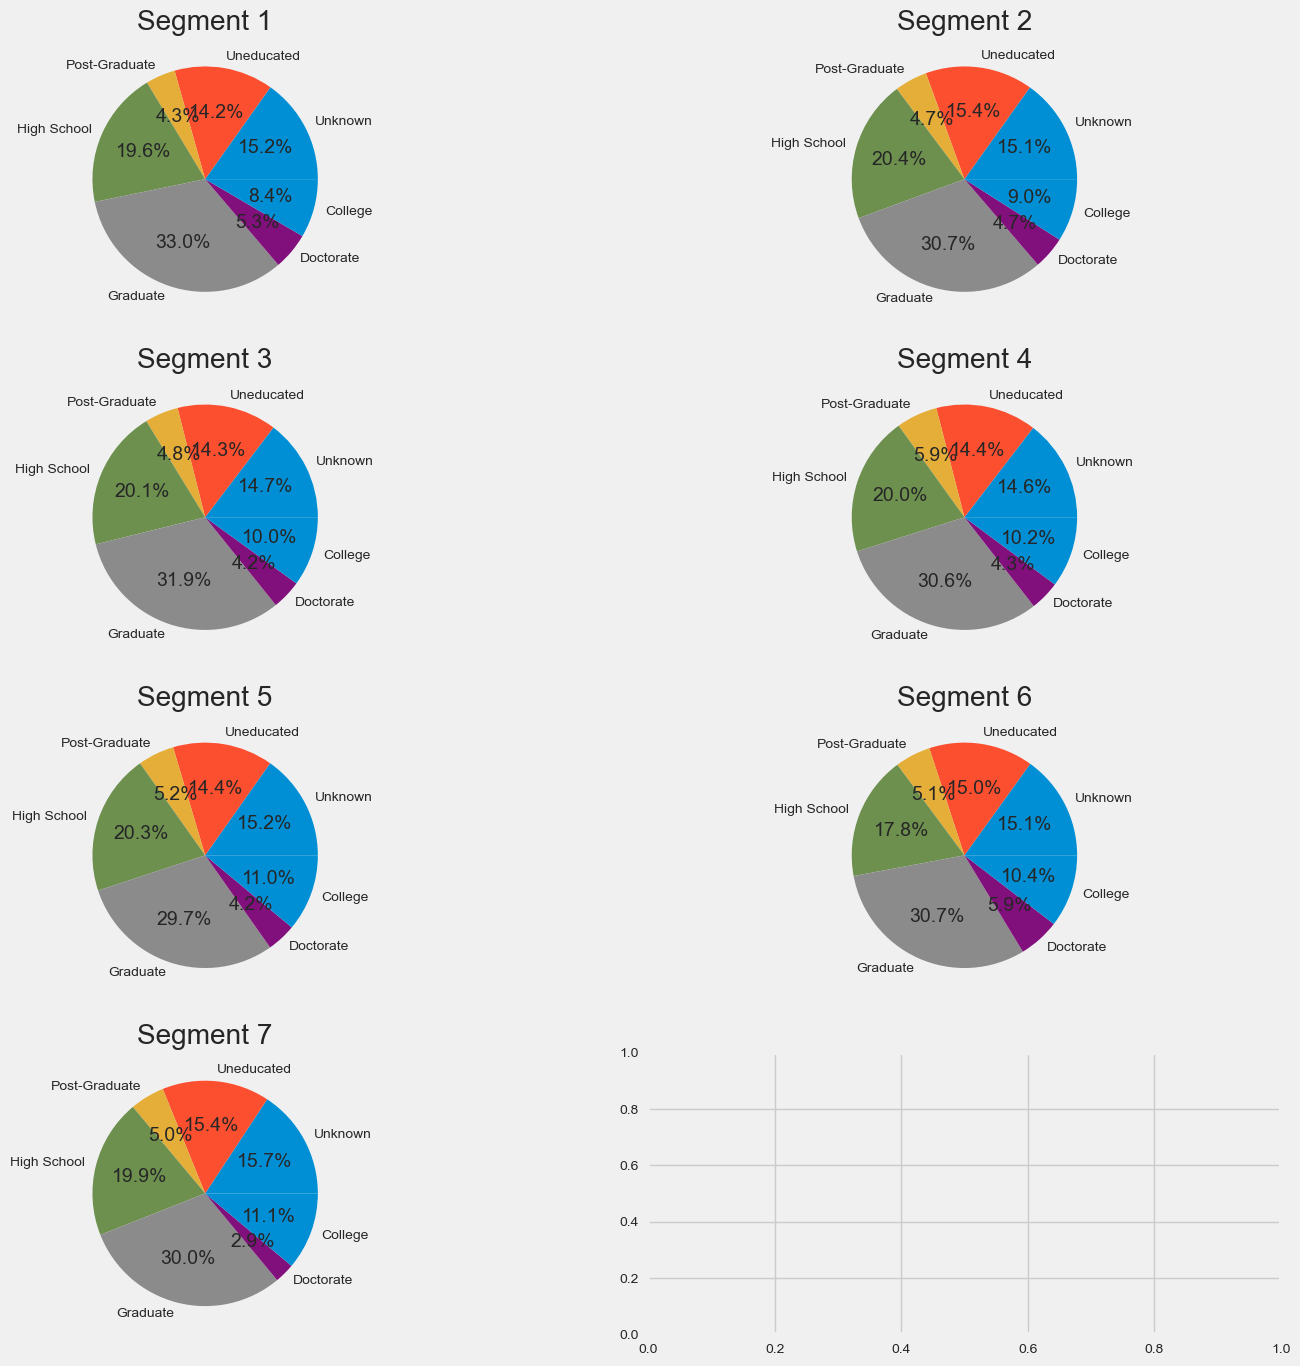

In [173]:
fix, axs = plt.subplots(ncols=2,nrows=4, figsize=(16,16))

df[df_behv_cluster['customer_group'] == 0]['Education_Level'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[0,0], ylabel='', title='Segment 1', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 1]['Education_Level'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[0,1], ylabel='', title='Segment 2', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 2]['Education_Level'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[1,0], ylabel='', title='Segment 3', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 3]['Education_Level'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[1,1], ylabel='', title='Segment 4', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 4]['Education_Level'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[2,0], ylabel='', title='Segment 5', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 5]['Education_Level'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[2,1], ylabel='', title='Segment 6', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 6]['Education_Level'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[3,0], ylabel='', title='Segment 7', autopct='%.1f%%')

#### Marital status

<AxesSubplot:title={'center':'Segment 7'}>

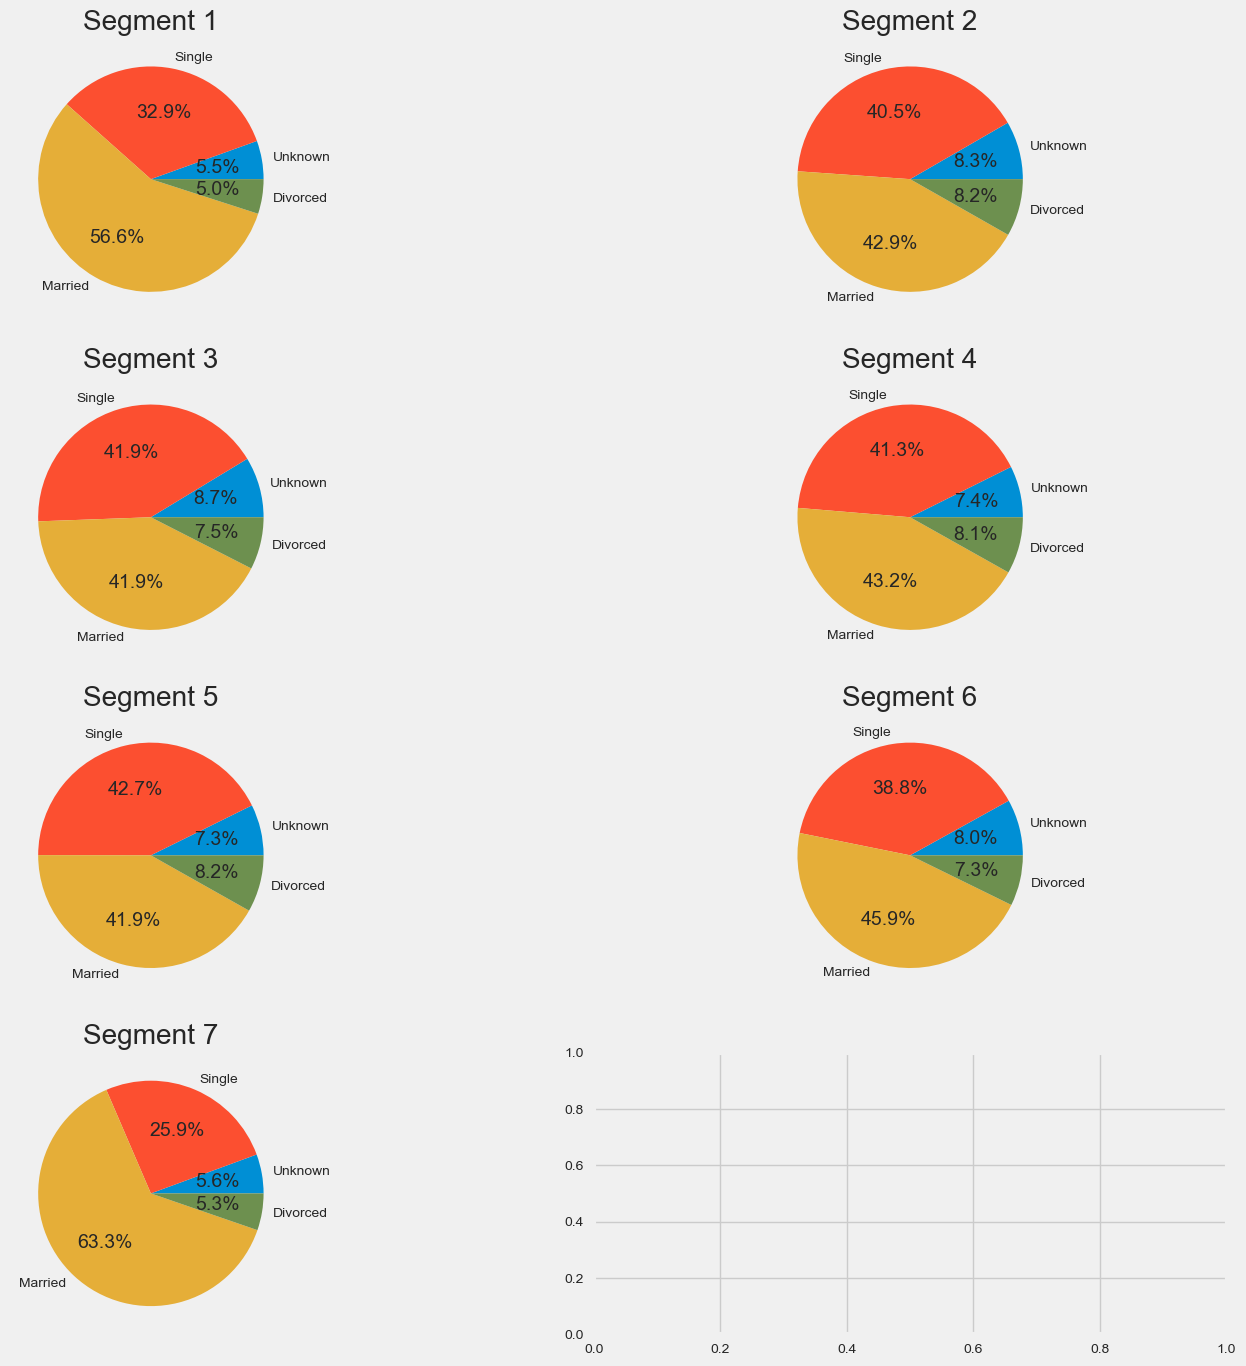

In [188]:
fix, axs = plt.subplots(ncols=2,nrows=4, figsize=(16,16))

df[df_behv_cluster['customer_group'] == 0]['Marital_Status'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[0,0], ylabel='', title='Segment 1', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 1]['Marital_Status'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[0,1], ylabel='', title='Segment 2', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 2]['Marital_Status'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[1,0], ylabel='', title='Segment 3', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 3]['Marital_Status'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[1,1], ylabel='', title='Segment 4', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 4]['Marital_Status'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[2,0], ylabel='', title='Segment 5', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 5]['Marital_Status'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[2,1], ylabel='', title='Segment 6', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 6]['Marital_Status'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[3,0], ylabel='', title='Segment 7', autopct='%.1f%%')

#### Income level

<AxesSubplot:title={'center':'Segment 7'}>

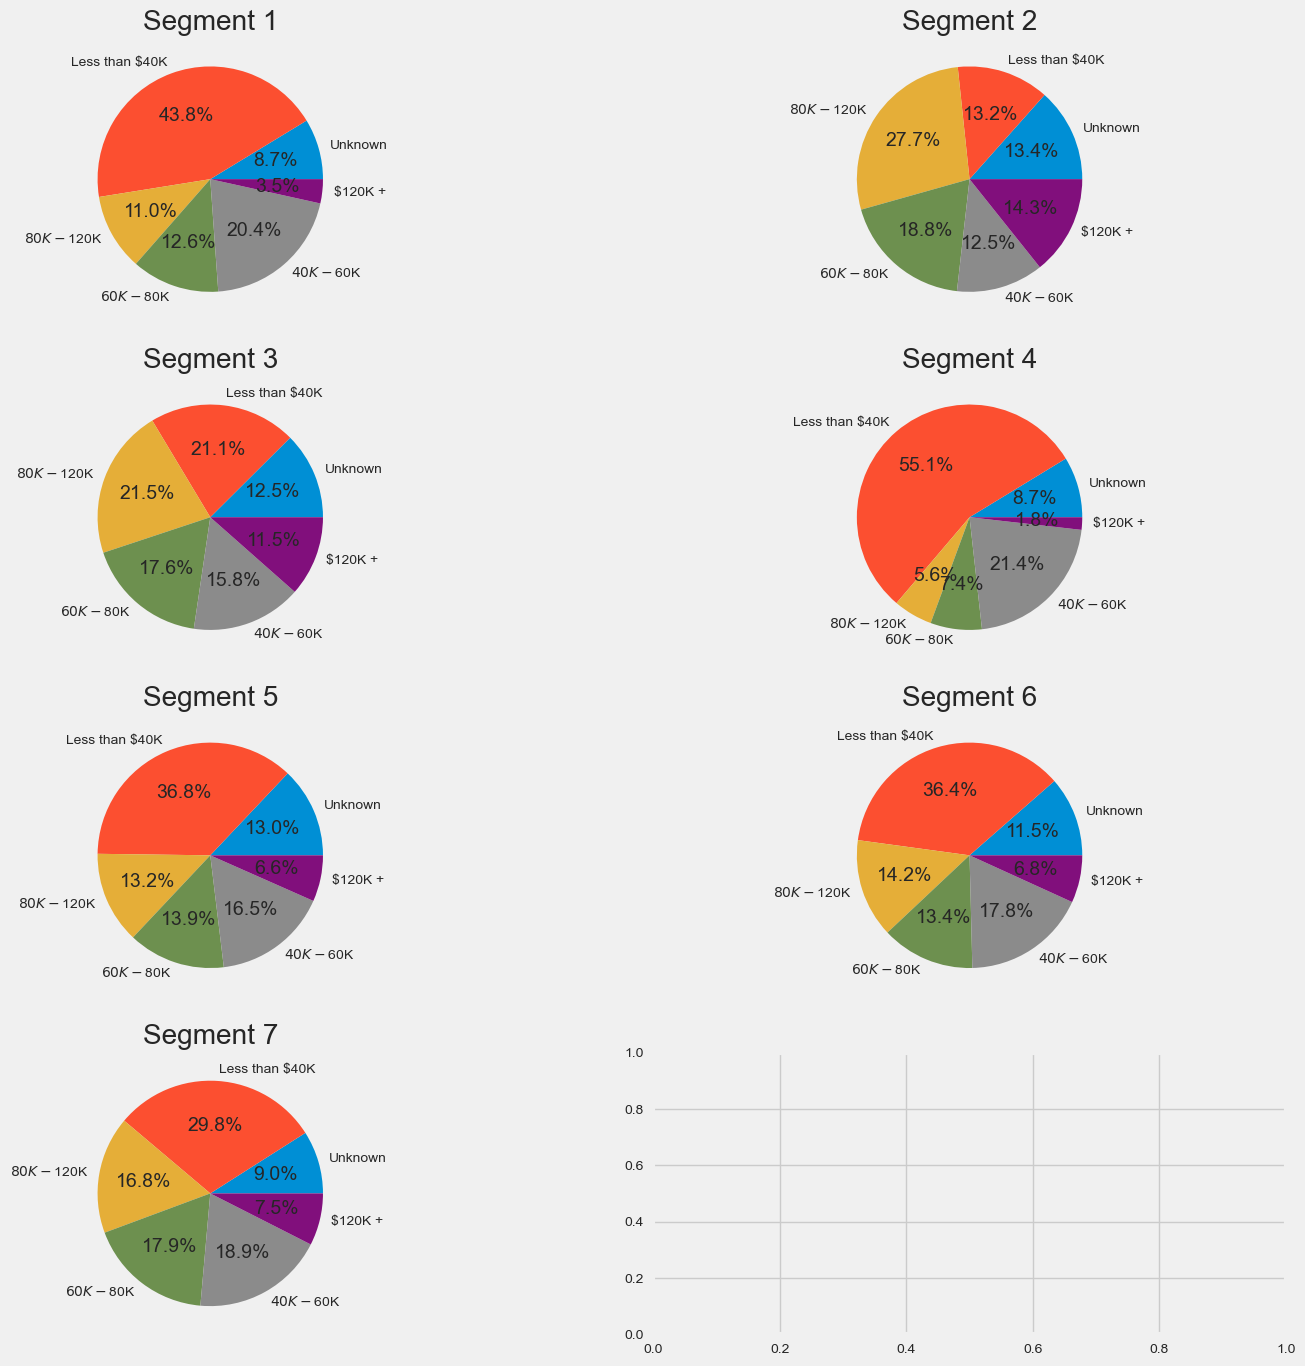

In [189]:
fix, axs = plt.subplots(ncols=2,nrows=4, figsize=(16,16))

df[df_behv_cluster['customer_group'] == 0]['Income_Category'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[0,0], ylabel='', title='Segment 1', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 1]['Income_Category'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[0,1], ylabel='', title='Segment 2', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 2]['Income_Category'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[1,0], ylabel='', title='Segment 3', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 3]['Income_Category'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[1,1], ylabel='', title='Segment 4', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 4]['Income_Category'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[2,0], ylabel='', title='Segment 5', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 5]['Income_Category'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[2,1], ylabel='', title='Segment 6', autopct='%.1f%%')
df[df_behv_cluster['customer_group'] == 6]['Income_Category'].value_counts().sort_index(ascending=False).plot.pie(ax=axs[3,0], ylabel='', title='Segment 7', autopct='%.1f%%')

#### Card type

<AxesSubplot:title={'center':'Segment 7'}>

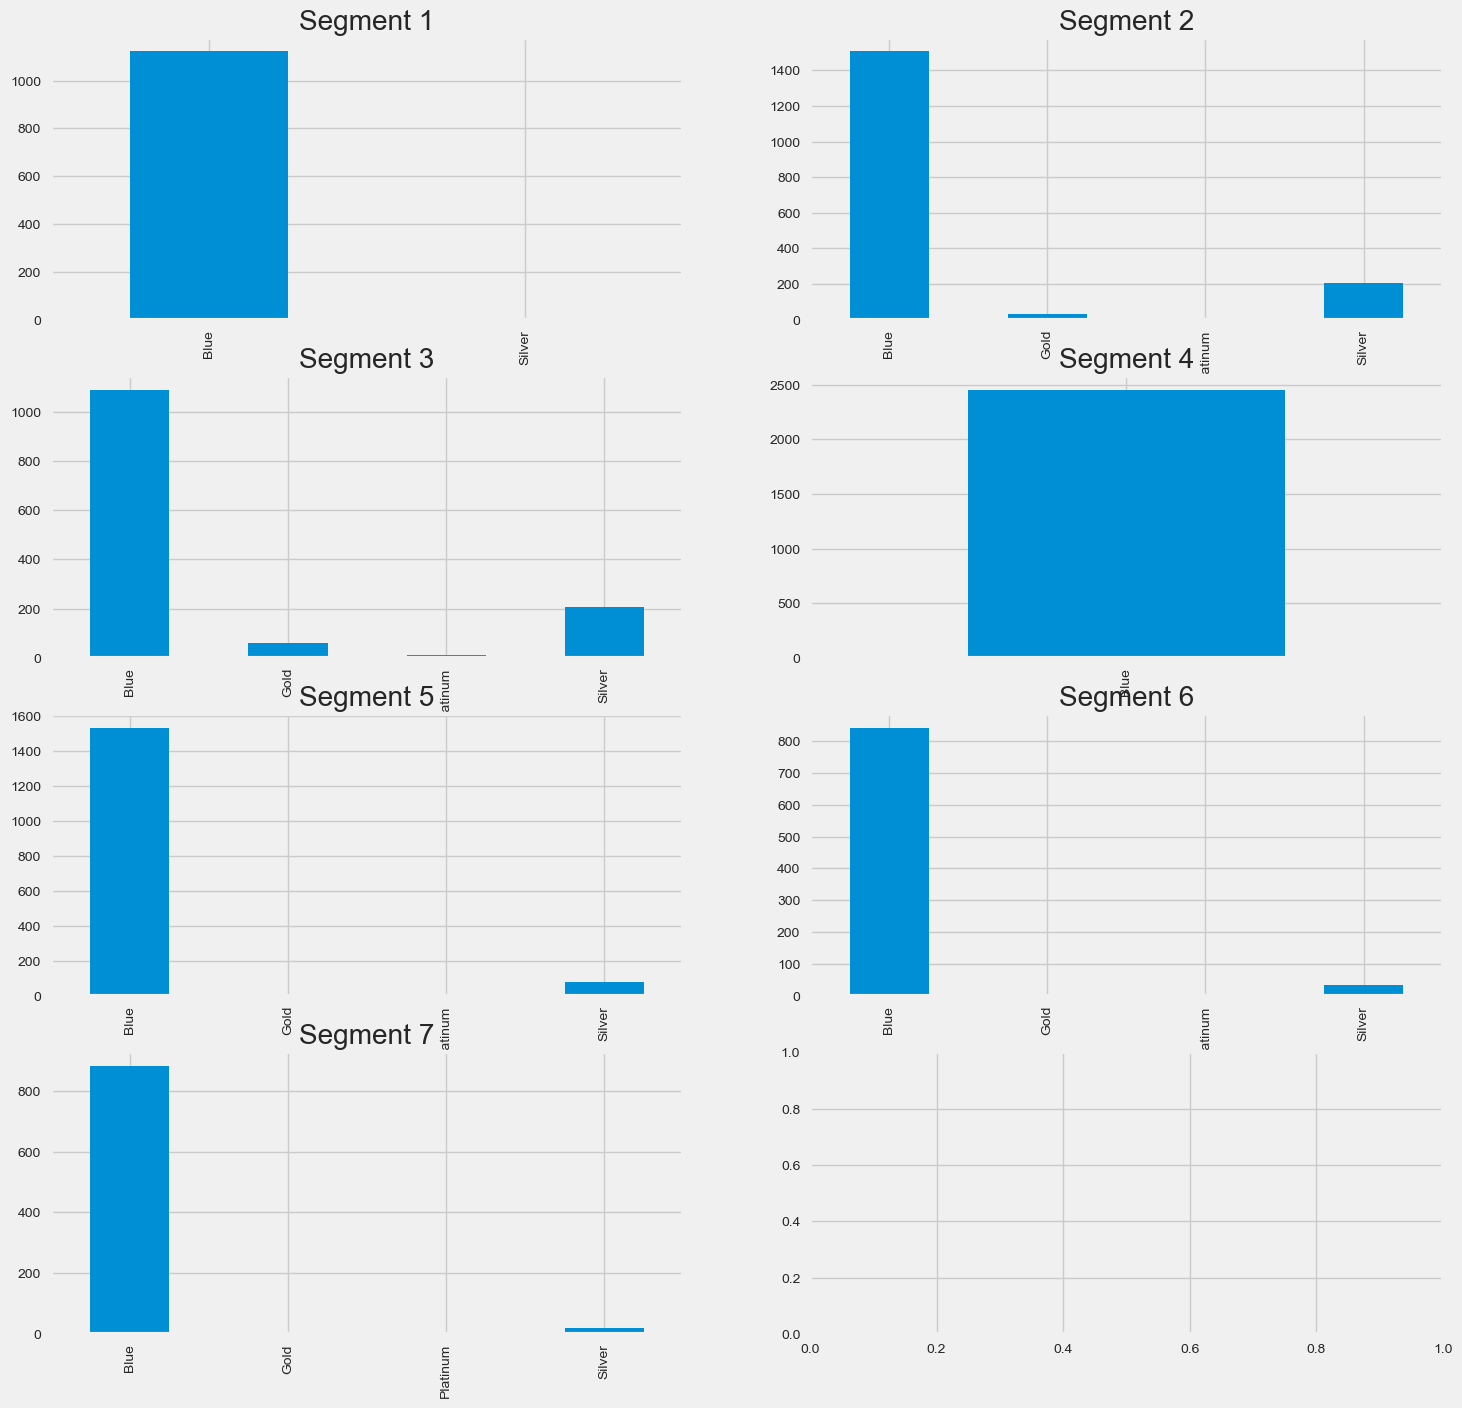

In [191]:
fix, axs = plt.subplots(ncols=2,nrows=4, figsize=(16,16))

df[df_behv_cluster['customer_group']==0]['Card_Category'].value_counts().sort_index().plot.bar(ax=axs[0,0], title='Segment 1')
df[df_behv_cluster['customer_group'] == 1]['Card_Category'].value_counts().sort_index().plot.bar(ax=axs[0,1], title='Segment 2')
df[df_behv_cluster['customer_group'] == 2]['Card_Category'].value_counts().sort_index().plot.bar(ax=axs[1,0], title='Segment 3')
df[df_behv_cluster['customer_group'] == 3]['Card_Category'].value_counts().sort_index().plot.bar(ax=axs[1,1], title='Segment 4')
df[df_behv_cluster['customer_group'] == 4]['Card_Category'].value_counts().sort_index().plot.bar(ax=axs[2,0], title='Segment 5')
df[df_behv_cluster['customer_group'] == 5]['Card_Category'].value_counts().sort_index().plot.bar(ax=axs[2,1], title='Segment 6')
df[df_behv_cluster['customer_group'] == 6]['Card_Category'].value_counts().sort_index().plot.bar(ax=axs[3,0], title='Segment 7')